# **Salifort Motors Employee Retention Project**

# **PACE stages**


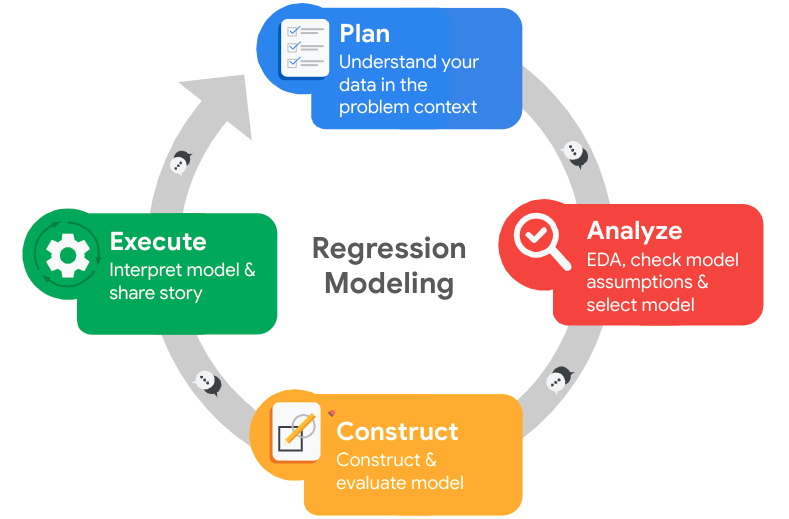

## **Pace: Plan**

### Understand the business scenario and problem

The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it. They refer to you as a data analytics professional and ask you to provide data-driven suggestions based on your understanding of the data. They have the following question: 

**What’s likely to make the employee leave the company?**

The goal in this project are to analyze the data collected by the HR department and to build a model that predicts whether or not an employee will leave the company.

By being able to predict how likely an employee is to leave the company, Salifort Motors can address the issues of those employees likely to leave. As well, the model can provide import insights into what are the highest drivers of attrition.

Increasing employee retention will improve the company in the following ways:
- No time and energy spent trying to hire a replacement
- No training needed to get a new hire up to speed
- No loss of specialized knowledge
- Keep the built relationships between coworkers

### Understanding the HR dataset

The dataset contains 15,000 rows and 10 columns for the variables listed below. 

**Note:** the original data can be found on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

#### Stakeholders
The stakeholders for this project are the executives, HR, and managers. They are the ones who will decide how the information discovered will be implemented into company policy. They are not as data knowledgable so the report to them must be business focused and not too much data jargon.

#### Main Objective
The main objective is to decrease the turnover rate at Salifort Motors. This problem may have a root cause that is uncovered in the data exploration or the data modeling.

#### Observations of the Data
I will be looking for completeness of the data, such as how many missing values. I will be looking at the distribution of data points for each variable. Is the target value imbalanced? Is there enough variation in the variables to create a signal for the model to learn the likelihood of leaving? Are there outliers that need to be removed to make sure that the model will generalize well?

#### Resources for Analysis
Use Python packages sklearn, xgboost, seaborn, scipy, statsmodels, and matplotlib to perform statistical and visual analysis of the data.

#### Ethical Considerations
When dealing with employee data, it is important to remove any demographic data that may create discriminatory bias based on a protected class. As well, it is a good idea to remove any identifiers of individuals, since this is an experiment and should not be applied to individuals until fully tested and verified. Looking at the dataset, I do not see any apparent ethical concerns. Personal characteristics such as race, gender, ethnicity, education, and other sensitive information is not included. 



### Import packages

In [72]:
# Import data manipulation packages
import pandas as pd
import numpy as np
import json

# import data viz packages
import matplotlib.pyplot as plt
import seaborn as sns

# import stats and modeling packages
import scipy as sp
from scipy.stats import uniform, truncnorm, randint, loguniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold, PredefinedSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# import explainability packages
from xgboost import plot_importance
import shap

import pickle
import warnings

warnings.filterwarnings('ignore')

### Load dataset

In [73]:
# Load dataset into a dataframe
sfmotors_df = pd.read_csv("../data/HR_capstone_dataset.csv")


# Display first few rows of the dataframe
sfmotors_df.head()


satisfaction_level  last_evaluation  number_project  average_montly_hours   
0                0.38             0.53               2                   157  \
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department   
0                   3              0     1                      0      sales  \
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

## Data Exploration (Initial EDA and data cleaning)


### Gather basic information about the data

In [74]:
# Gather basic information about the data
sfmotors_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Basic Info Analysis:
- There are no missing data points. This makes cleaning a little easier. 
- There are two categorical variables that will need to be one hot encoded (Department, salary)

### Gather descriptive statistics about the data

In [75]:
# Gather descriptive statistics about the data
sfmotors_df.describe()


satisfaction_level  last_evaluation  number_project   
count        14999.000000     14999.000000    14999.000000  \
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left   
count          14999.000000        14999.000000   14999.000000  14999.000000  \
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000   
25%              156.000000            3.000000       0.000000      0.000000   
50%              200.000000            3.000000       0.000000      0.000000   
75%              245.000000            4.000000       0.000000      0.000000   
max              310.000000           10.000000       1.000000      1.000000   

       promotion_last_5years  
count           14999.000000  
mean                0.021268  
std                 0.144281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

### Descriptive Statistic Analysis:

- There are **two binary variables**: 
    - Work_accident
    - promotion_last_5years
- There are **two continuous variables** that have a **range of 0 to 1.0**: 
    - satisfaction_level
    - last_evaluation
- There are **three discrete numerical variables**: 
    - number_project
    - average_monthly_hours
    - time_spend_company
- The **target variable (left) is binary** and based on the mean, is **imbalanced 76% with 0 and 24% with 1**.

### Rename columns
Fix typos and standardize the naming format for all of the columns

In [76]:
# Display all column names
sfmotors_df.columns


Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [77]:
# Rename columns using the lower() function
sfmotors_df.columns = [col.lower() for col in sfmotors_df.columns]

# fix the typo in average_montly_hours
sfmotors_df = sfmotors_df.rename(columns={'average_montly_hours':'average_monthly_hours'})


# Display all column names after the update
sfmotors_df.columns


Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

### Check missing values

Check for any missing values in the data.

In [78]:
# Check for missing values
sfmotors_df.isna().sum()


satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
time_spend_company       0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

### Check duplicates

Check for any duplicate entries in the data.

In [79]:
# Check for duplicates
duplicate_count = sfmotors_df.duplicated().sum()
print(f'There are {duplicate_count} duplicates')
print(f'Which is {round(100*duplicate_count/sfmotors_df.shape[0])}% of the rows')



There are 3008 duplicates
Which is 20% of the rows


In [80]:
# Inspect some rows containing duplicates as needed
duplicate_rows = sfmotors_df[sfmotors_df.duplicated()]
duplicate_rows.head(10)


satisfaction_level  last_evaluation  number_project   
396                  0.46             0.57               2  \
866                  0.41             0.46               2   
1317                 0.37             0.51               2   
1368                 0.41             0.52               2   
1461                 0.42             0.53               2   
1516                 0.40             0.50               2   
1616                 0.37             0.46               2   
1696                 0.39             0.56               2   
1833                 0.10             0.85               6   
12000                0.38             0.53               2   

       average_monthly_hours  time_spend_company  work_accident  left   
396                      139                   3              0     1  \
866                      128                   3              0     1   
1317                     127                   3              0     1   
1368                     132                   3              0     1   
1461                     142                   3              0     1   
1516                     127                   3              0     1   
1616                     156                   3              0     1   
1696                     160                   3              0     1   
1833                     266                   4              0     1   
12000                    157                   3              0     1   

       promotion_last_5years  department  salary  
396                        0       sales     low  
866                        0  accounting     low  
1317                       0       sales  medium  
1368                       0       RandD     low  
1461                       0       sales     low  
1516                       0          IT     low  
1616                       0       sales     low  
1696                       0       sales     low  
1833                       0       sales     low  
12000                      0       sales     low

In [81]:
# Drop duplicates and save resulting dataframe in a new variable as needed
no_dupes_df = sfmotors_df[~sfmotors_df.duplicated()]


# Display the number of rows for the dataframe with no duplicates vs the original dataframe
print(f'Original dataframe had {sfmotors_df.shape[0]} rows')
print(f'New dataframe with no duplicates has {no_dupes_df.shape[0]} rows')



Original dataframe had 14999 rows
New dataframe with no duplicates has 11991 rows


### Check outliers

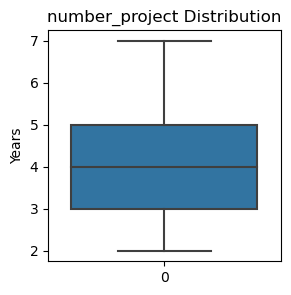

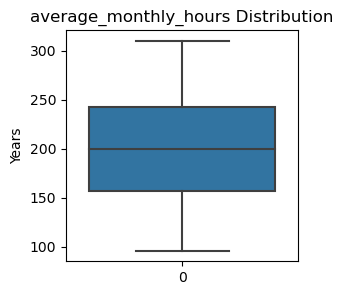

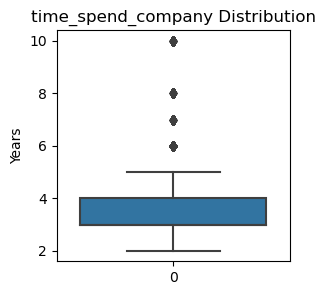

In [82]:
# Create a boxplot to visualize distribution of values and detect any outliers
discrete_cols = ['number_project', 'average_monthly_hours', 'time_spend_company']

for col in discrete_cols:
    plt.figure(figsize=(3, 3))
    sns.boxplot(data=no_dupes_df[col])
    plt.title(f'{col} Distribution')
    plt.ylabel('Years')
    plt.show()


### Analysis of the Boxplots:
The only discrete numeric column with outliers Is:
- time_spend_company
  
This looks like accurate data so it should not be removed.

In [83]:
# Determine the number of rows containing outliers
def outliers_limits(df, cols):
    for col in cols:
        iqr = sp.stats.iqr(df[col])
        quartiles = df[col].quantile([0.25, 0.5, 0.75])
        q1 = quartiles[0.25]
        q3 = quartiles[0.75]
        upper_limit = (1.5*iqr) + q3
        lower_limit = q1 - (1.5*iqr)
        outlier_col = col + '_outlier'
        df[outlier_col] = df[col].apply(lambda x: 1 if x > upper_limit or x < lower_limit else 0)
        
    return df

outlier_df = outliers_limits(no_dupes_df, ['time_spend_company'])

print(f'For Time Spent at the Company the oultiers are {round(100*outlier_df["time_spend_company_outlier"].sum() / outlier_df.shape[0])}%')



For Time Spent at the Company the oultiers are 7%


# Analyze Stage
### Analyze relationships between varables



In [84]:
# Get numbers of people who left vs. stayed
employees_left = no_dupes_df['left'].sum()

# Get percentages of people who left vs. stayed
pct_left = employees_left / no_dupes_df.shape[0]
print(f'The percent of employees who left is {round(100*pct_left, 1)}%')

The percent of employees who left is 16.6%


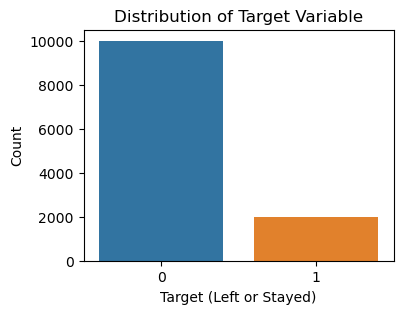

In [85]:
# plot the distribution of the target variable
plt.figure(figsize=(4, 3))
sns.countplot(data=no_dupes_df, x='left')
plt.title('Distribution of Target Variable')
plt.xlabel('Target (Left or Stayed)')
plt.ylabel('Count')
plt.show()

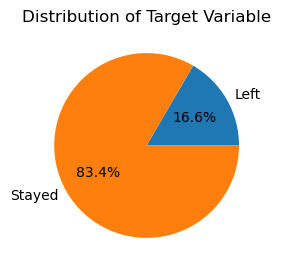

In [86]:
# plot the distribution of the target variable as a pie chart
plt.figure(figsize=(4, 3))
plt.pie([employees_left, no_dupes_df.shape[0] - employees_left], labels=['Left', 'Stayed'], autopct='%1.1f%%')
plt.title('Distribution of Target Variable')
plt.show()

### Target Analysis:
The target is **severely imbalanced** and will need some weights applied for the modeling or threshold tuning.

### Data visualizations

Visualize relationships between variables in the data.

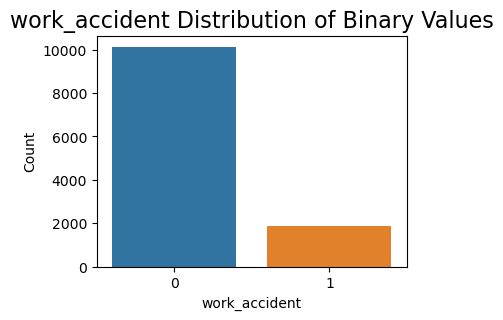

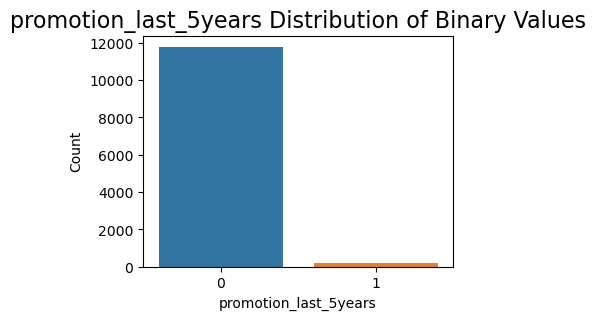

In [87]:
# view distribution of the binary targets
binary_cols = ['work_accident', 'promotion_last_5years']
for col in binary_cols:
    plt.figure(figsize=(4, 3))
    val_counts = no_dupes_df[col].value_counts().reset_index()
    sns.barplot(data=val_counts, x=val_counts.columns[0], y=val_counts.columns[1])
    plt.title(f'{col} Distribution of Binary Values', fontsize=16)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

### Binary Columns Analysis:
- **Work Accident** is severely imbalanced, which seems normal and we would assume that work accident employees are more likely to leave. So this features on first glance looks correct and important.


- **Promotion Last 5 Years** is even more severely imbalanced, which seems odd. 
    - **Potential Confounder:**  If the company is made up of **mostly new employees**, then they did not have the opportunity to reach 5 years. For instance, if most employees are 1 to 2 years, then it seems appropriate that they may not have gotten a promotion. The distribution of Years of Service will have to be analyzed. As well, **feature engineering** a new feature which looks at **whether an employee has been there for at least 5 years and has not had a promotion** may be a good feature to exclude new employees from this signal.

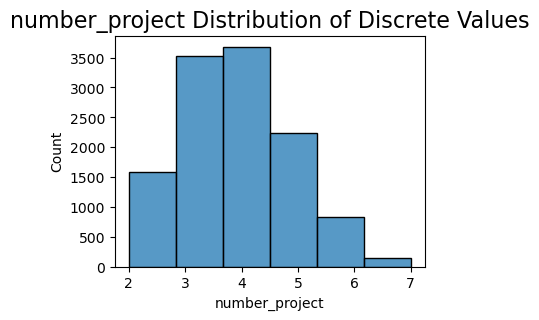

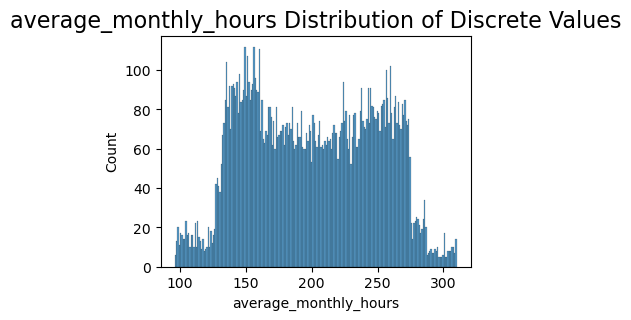

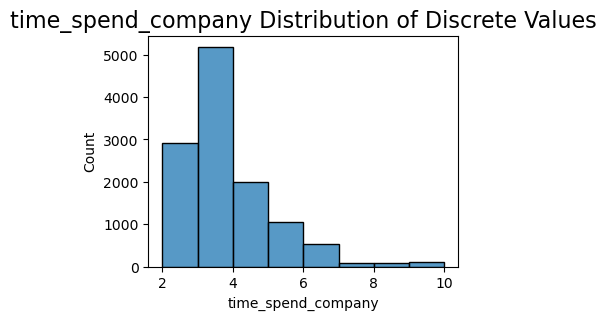

In [88]:
# Look at the distribution of discrete numeric columns
for col in discrete_cols:
    plt.figure(figsize=(4, 3))
    sns.histplot(data=no_dupes_df[col], bins=no_dupes_df[col].nunique())
    plt.title(f'{col} Distribution of Discrete Values', fontsize=16)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


### Analysis of the Discrete Variables
- **Number of Projects:** 
    - Looks to be a fairly **normal distribution**. The correlation of this to the target and to the average monthly hours will be interesting follow-up.


- **Average Monthly Hours:** 
    - This is **not a normal distribution** since it looks to be a saddle shape between 150 and 270 hours. There are no outliers, as that was explored in the boxplots. This variable will be looked for correlation with other variables but overall looks to be a good variable.


- **Time Spend at Company:** 
    - This **right skewed** and has been shown to have some outliers. Those outliers may give a significant story for the reason for turnover. For instance, if the >6 year employees have fewer projects or fewer monthly hours, then perhaps they show that the newer employees may need lower hours or fewer projects. The outlier issue will be compared more later.

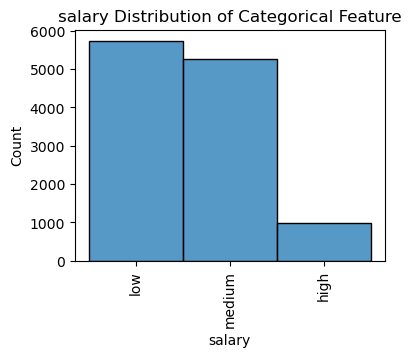

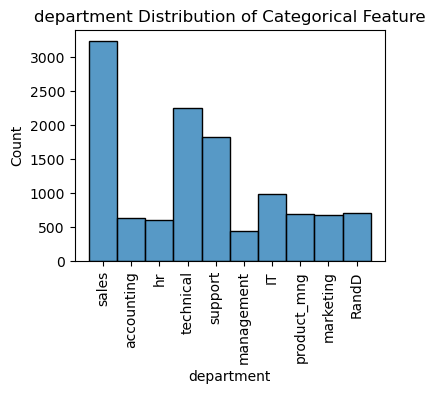

In [89]:
# view the categorical features
cat_cols = ['salary', 'department']
for col in cat_cols:
    plt.figure(figsize=(4, 3))
    sns.histplot(data=no_dupes_df[col], bins=no_dupes_df[col].nunique())
    plt.title(f'{col} Distribution of Categorical Feature')
    plt.xlabel(col)
    plt.xticks(rotation=90)
    plt.ylabel('Count')
    plt.show()


### Categorical Features Analysis:
- **Salary**: 
    - This distribution is **right skewed**, which is too be expected as companies tend to have incomes distribution imbalanced towards the top where there are fewer roles.


- **Department**: 
    - Has a **non-uniform distribution** with Sales, Technical, and Support being quite large comparatively. There may be a feature to engineer between **Department and Salary** since certain fields may be more accepting of a low salary compared to others.

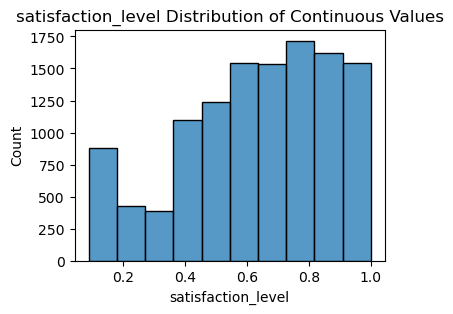

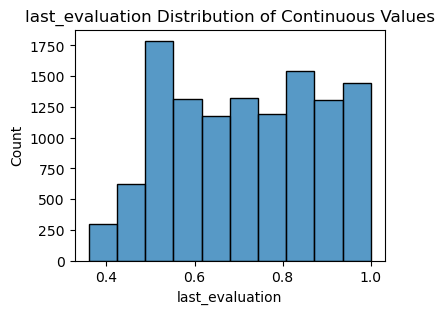

In [90]:
# view the distribution of continuous features
continuous_cols = ['satisfaction_level', 'last_evaluation']
for col in continuous_cols:
    plt.figure(figsize=(4, 3))
    sns.histplot(data=no_dupes_df[col], bins=10)
    plt.title(f'{col} Distribution of Continuous Values')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


### Continuous Features Analysis:
- **Satisfaction Level**: 
    - The distribution has **a lot of positive reviews**. If there was a real problem with the company, I would expect a more normal or right-skewed distribution of satisfaction. The **correlation between this feature and others, including the target** will be very interesting.
    - **Consideration:** How honest are the employees? If the employees thought the survey could be linked back to them, then they may not give an honest rating. 


- **Last Evaluation**: 
    - The distribution is **not-normally** distributed and there is a spike at 0.5. There could be an issue with low-evaluations causing employees to feel not valued. This will be something to keep in mind, since they seem to be satisfied but perhaps they are getting bad reviews which they leads to them being disappointed.

## Cross Correlation

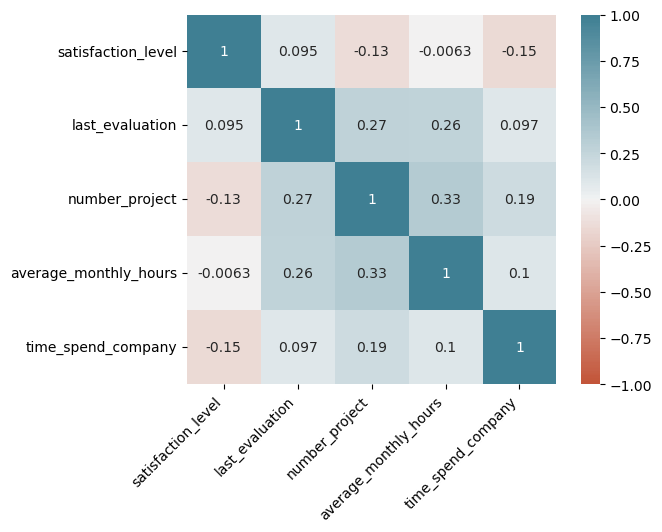

In [91]:
# view the correlation plot of non-binary columns
non_binary_cols = continuous_cols + discrete_cols
corr = no_dupes_df[non_binary_cols].corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show()

### Numeric Column Cross-Correlation Analysis:
- **No significant cross-correlation** in the **continuous and discrete variables**.

## Feature Pair Plots

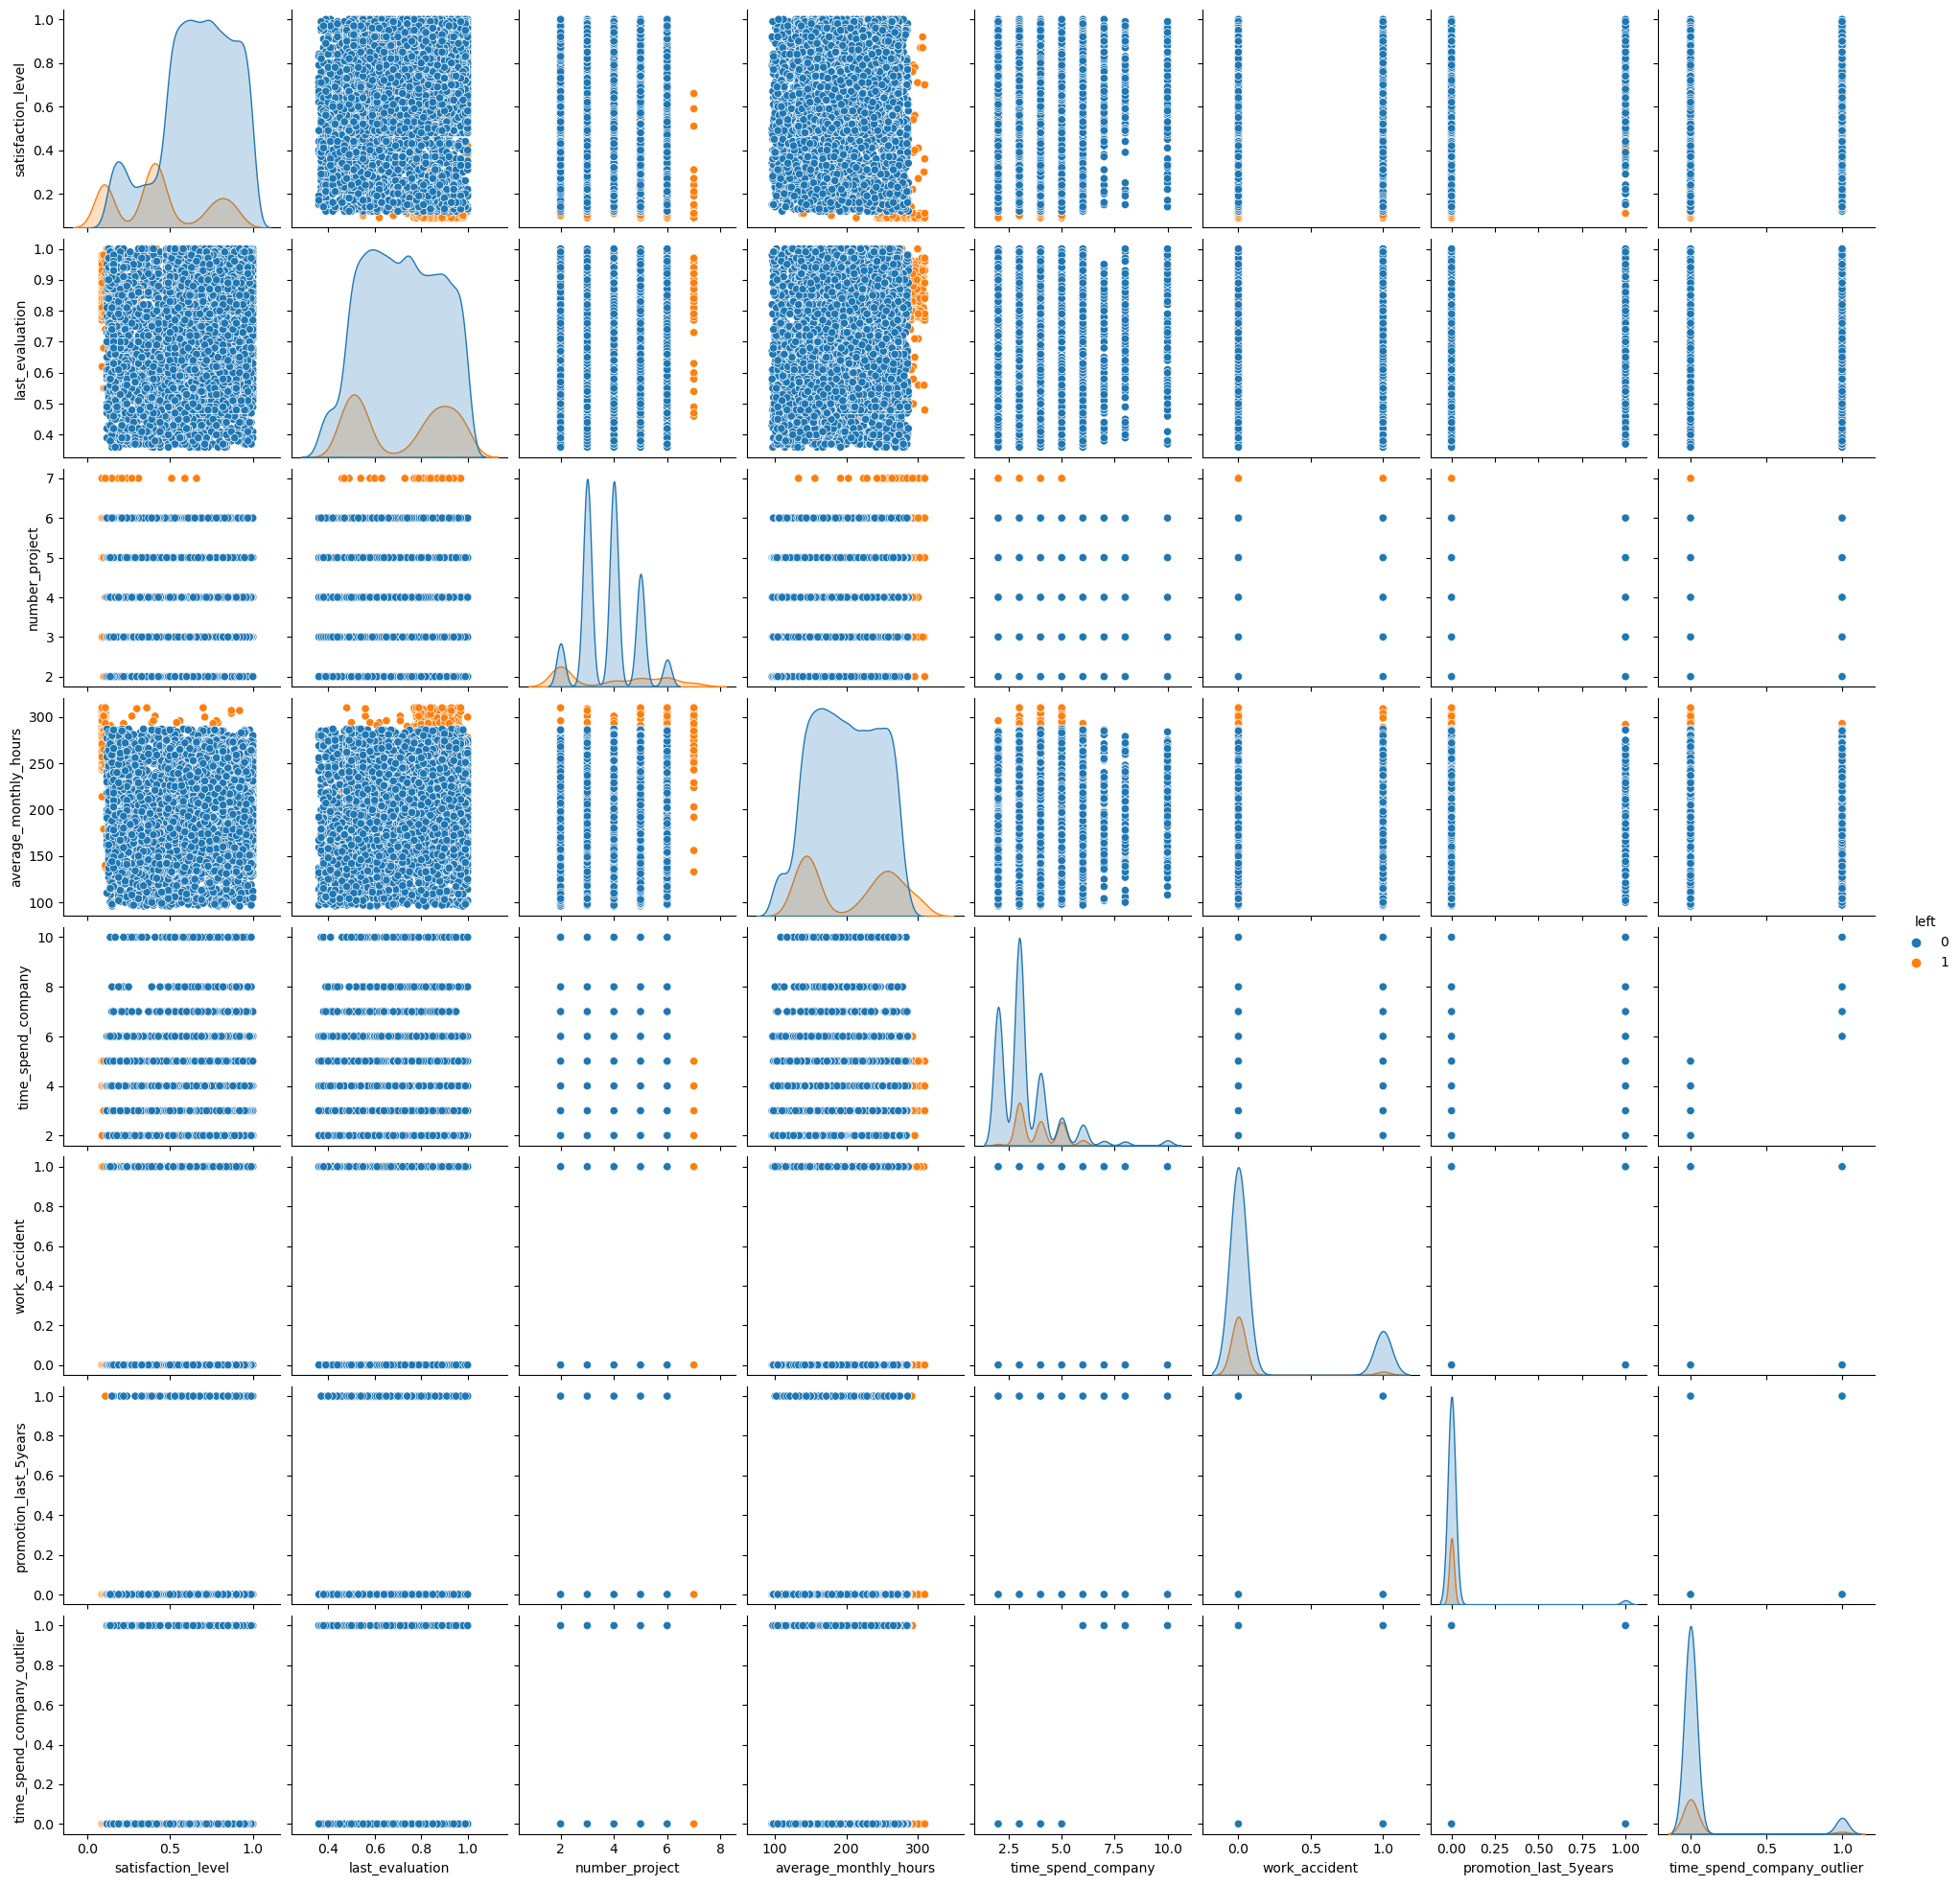

In [92]:
# Create a scatter plot looking at relationships between features
sns.pairplot(data=no_dupes_df, hue='left')
plt.show()


### Pair Plot Analysis:

This is very insightful and by using the hue set to the target, there are some very significant patterns viewable.

- **Satisfaction Level**: 
    - If the satisfaction level is low, then the employee tends to leave.
- **Number of Projects**:
    - If the number of projects is high, then the employee tends to leave.
- **Average Monthly Hours**:
    - If the number of average monthly hours is high, then the employee tends to leave.
- **Time Spend at the Company**:
    - The employees who leave, tend to be 5 for fewer years with a combination of either high number of projects or high number of average monthly hours or very low satisfaction level.
    
#### It seems that almost all of the prediction could be done using these four features. This will be kept in mind later.

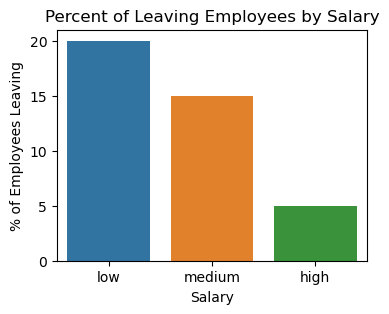

In [93]:
# view the percent of employees who left based on their salary
salary_left = no_dupes_df.groupby(['salary'])['left'].mean().reset_index()
salary_left['left'] = salary_left['left'].apply(lambda x: round(100*x))
salary_left = salary_left.rename(columns={'left':'percent_left'})

plt.figure(figsize=(4, 3))
sns.barplot(data = salary_left, x='salary', y='percent_left', order=['low', 'medium', 'high'])
plt.title('Percent of Leaving Employees by Salary')
plt.xlabel('Salary')
plt.ylabel('% of Employees Leaving')
plt.show()

### Salary and Left Analysis:
The salary of employees does appear to have an impact on whether employees leave. 

### Follow-Up Question
**Would a higher salary keep employees even if they have many projects and many hours?**

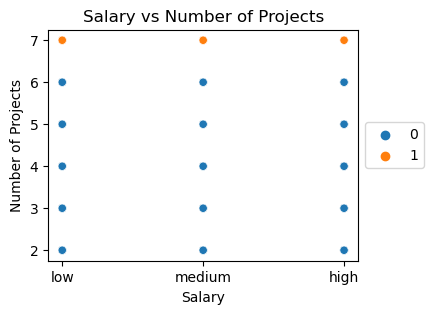

In [94]:
no_dupes_df[['salary', 'number_project', 'left']]
plt.figure(figsize=(4, 3))
sns.scatterplot(data=no_dupes_df, x='salary', y='number_project', hue='left')
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Salary vs Number of Projects')
plt.ylabel('Number of Projects')
plt.xlabel('Salary')
plt.show()

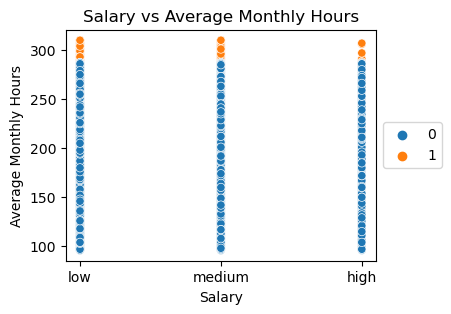

In [95]:
no_dupes_df[['salary', 'average_monthly_hours', 'left']]
plt.figure(figsize=(4, 3))
sns.scatterplot(data=no_dupes_df, x='salary', y='average_monthly_hours', hue='left')
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Salary vs Average Monthly Hours')
plt.ylabel('Average Monthly Hours')
plt.xlabel('Salary')
plt.show()

### Salary vs Number of Projects and Monthly Hours Analysis:
- The higher salary still sees people leave at a higher rate when they are working on 7 projects compared to those working on less than 7.
- The higher salary does not keep people from leaving when they have monthly hours above 275.

## Analysis of Employees Who Left

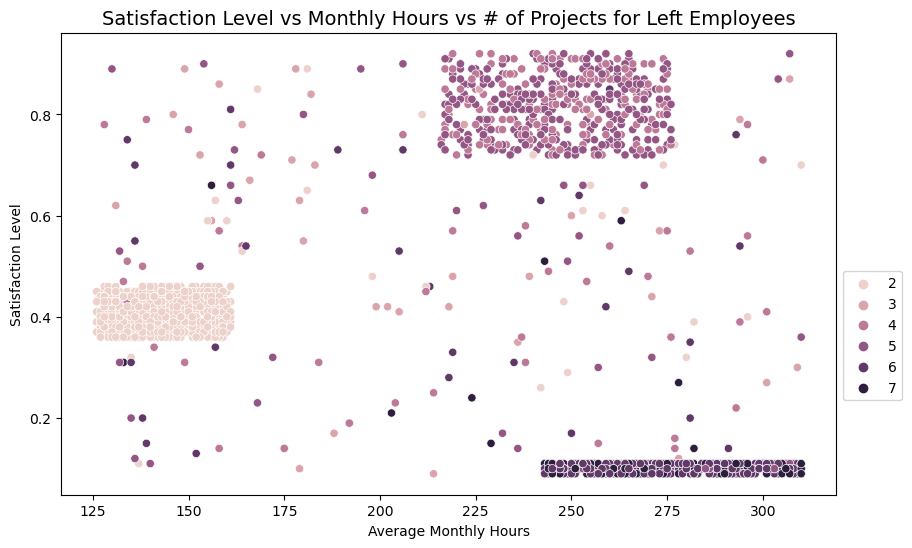

In [96]:
# look at the users who left with low satisfaction level and monthly hours
user_left = no_dupes_df[no_dupes_df['left'] == 1]
user_left['left'] = 'Employee Left'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_left, x='average_monthly_hours', y='satisfaction_level', hue='number_project')
plt.title('Satisfaction Level vs Monthly Hours vs # of Projects for Left Employees', fontsize=14)
plt.xlabel('Average Monthly Hours')
plt.ylabel('Satisfaction Level')
plt.legend(bbox_to_anchor= (1.0, 0.5))
plt.show()

#### Monthly Hours vs Satisfaction vs # of Projects Analysis:
- There seems to be three distict employee groups that leave based on satisfaction ratings:
    - **Low Satisfaction Group** that have high monthly hours and high number of projects
        - Satisfaction < 0.1
        - Average Monthly Hours > 240
    - **Mid Satisfaction Group** that has as a low number of projects and a low number of projects
        - Satisfaction between 0.35 to 0.45
        - Average Monthly Hours between 125 to 165
    - **High Satisfaction Group** that has a mid-to-high number of projects and work a mid-to-high number of hours
        - Satisfaction > 0.7
        - Average Monthly Hours between 215 to 275

## Analysis of Employees Who Stay

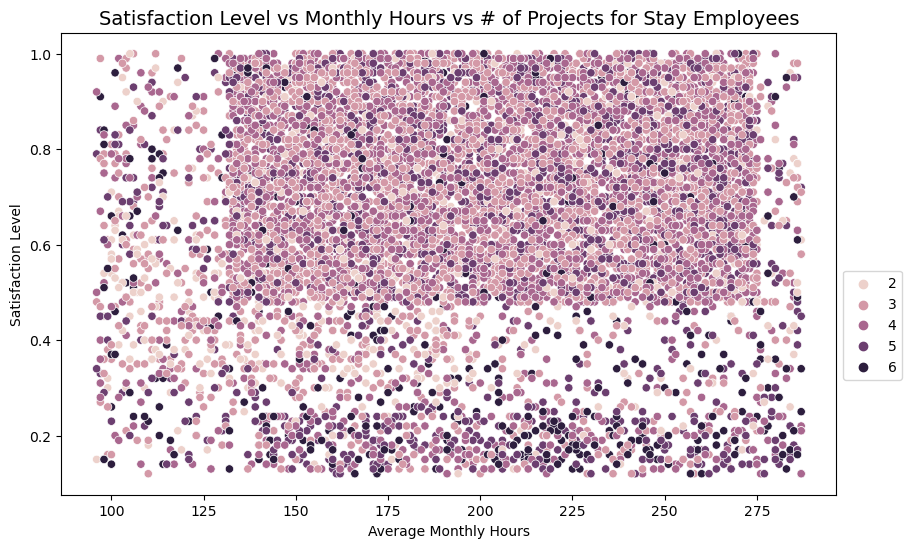

In [97]:
# look at the users who did not leave comparing satisfaction levels and monthly hours
user_stayed = no_dupes_df[no_dupes_df['left'] == 0]
user_stayed['left'] = 'Employee Stayed'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=user_stayed, x='average_monthly_hours', y='satisfaction_level', hue='number_project')
plt.title('Satisfaction Level vs Monthly Hours vs # of Projects for Stay Employees', fontsize=14)
plt.xlabel('Average Monthly Hours')
plt.ylabel('Satisfaction Level')
plt.legend(bbox_to_anchor= (1.0, 0.5))
plt.show()

### Analysis of the Users Who did not Leave:
- There is a fairly even distribution of satisfaction levels, hours worked, and projects below 7 projects.

#### Since there is no true pattern among the employees who stayed, but there are strong patterns among the employees who left, the clusters of leaving employees will be explored more.

## High Satisfaction Group with Mid-to-High Hours

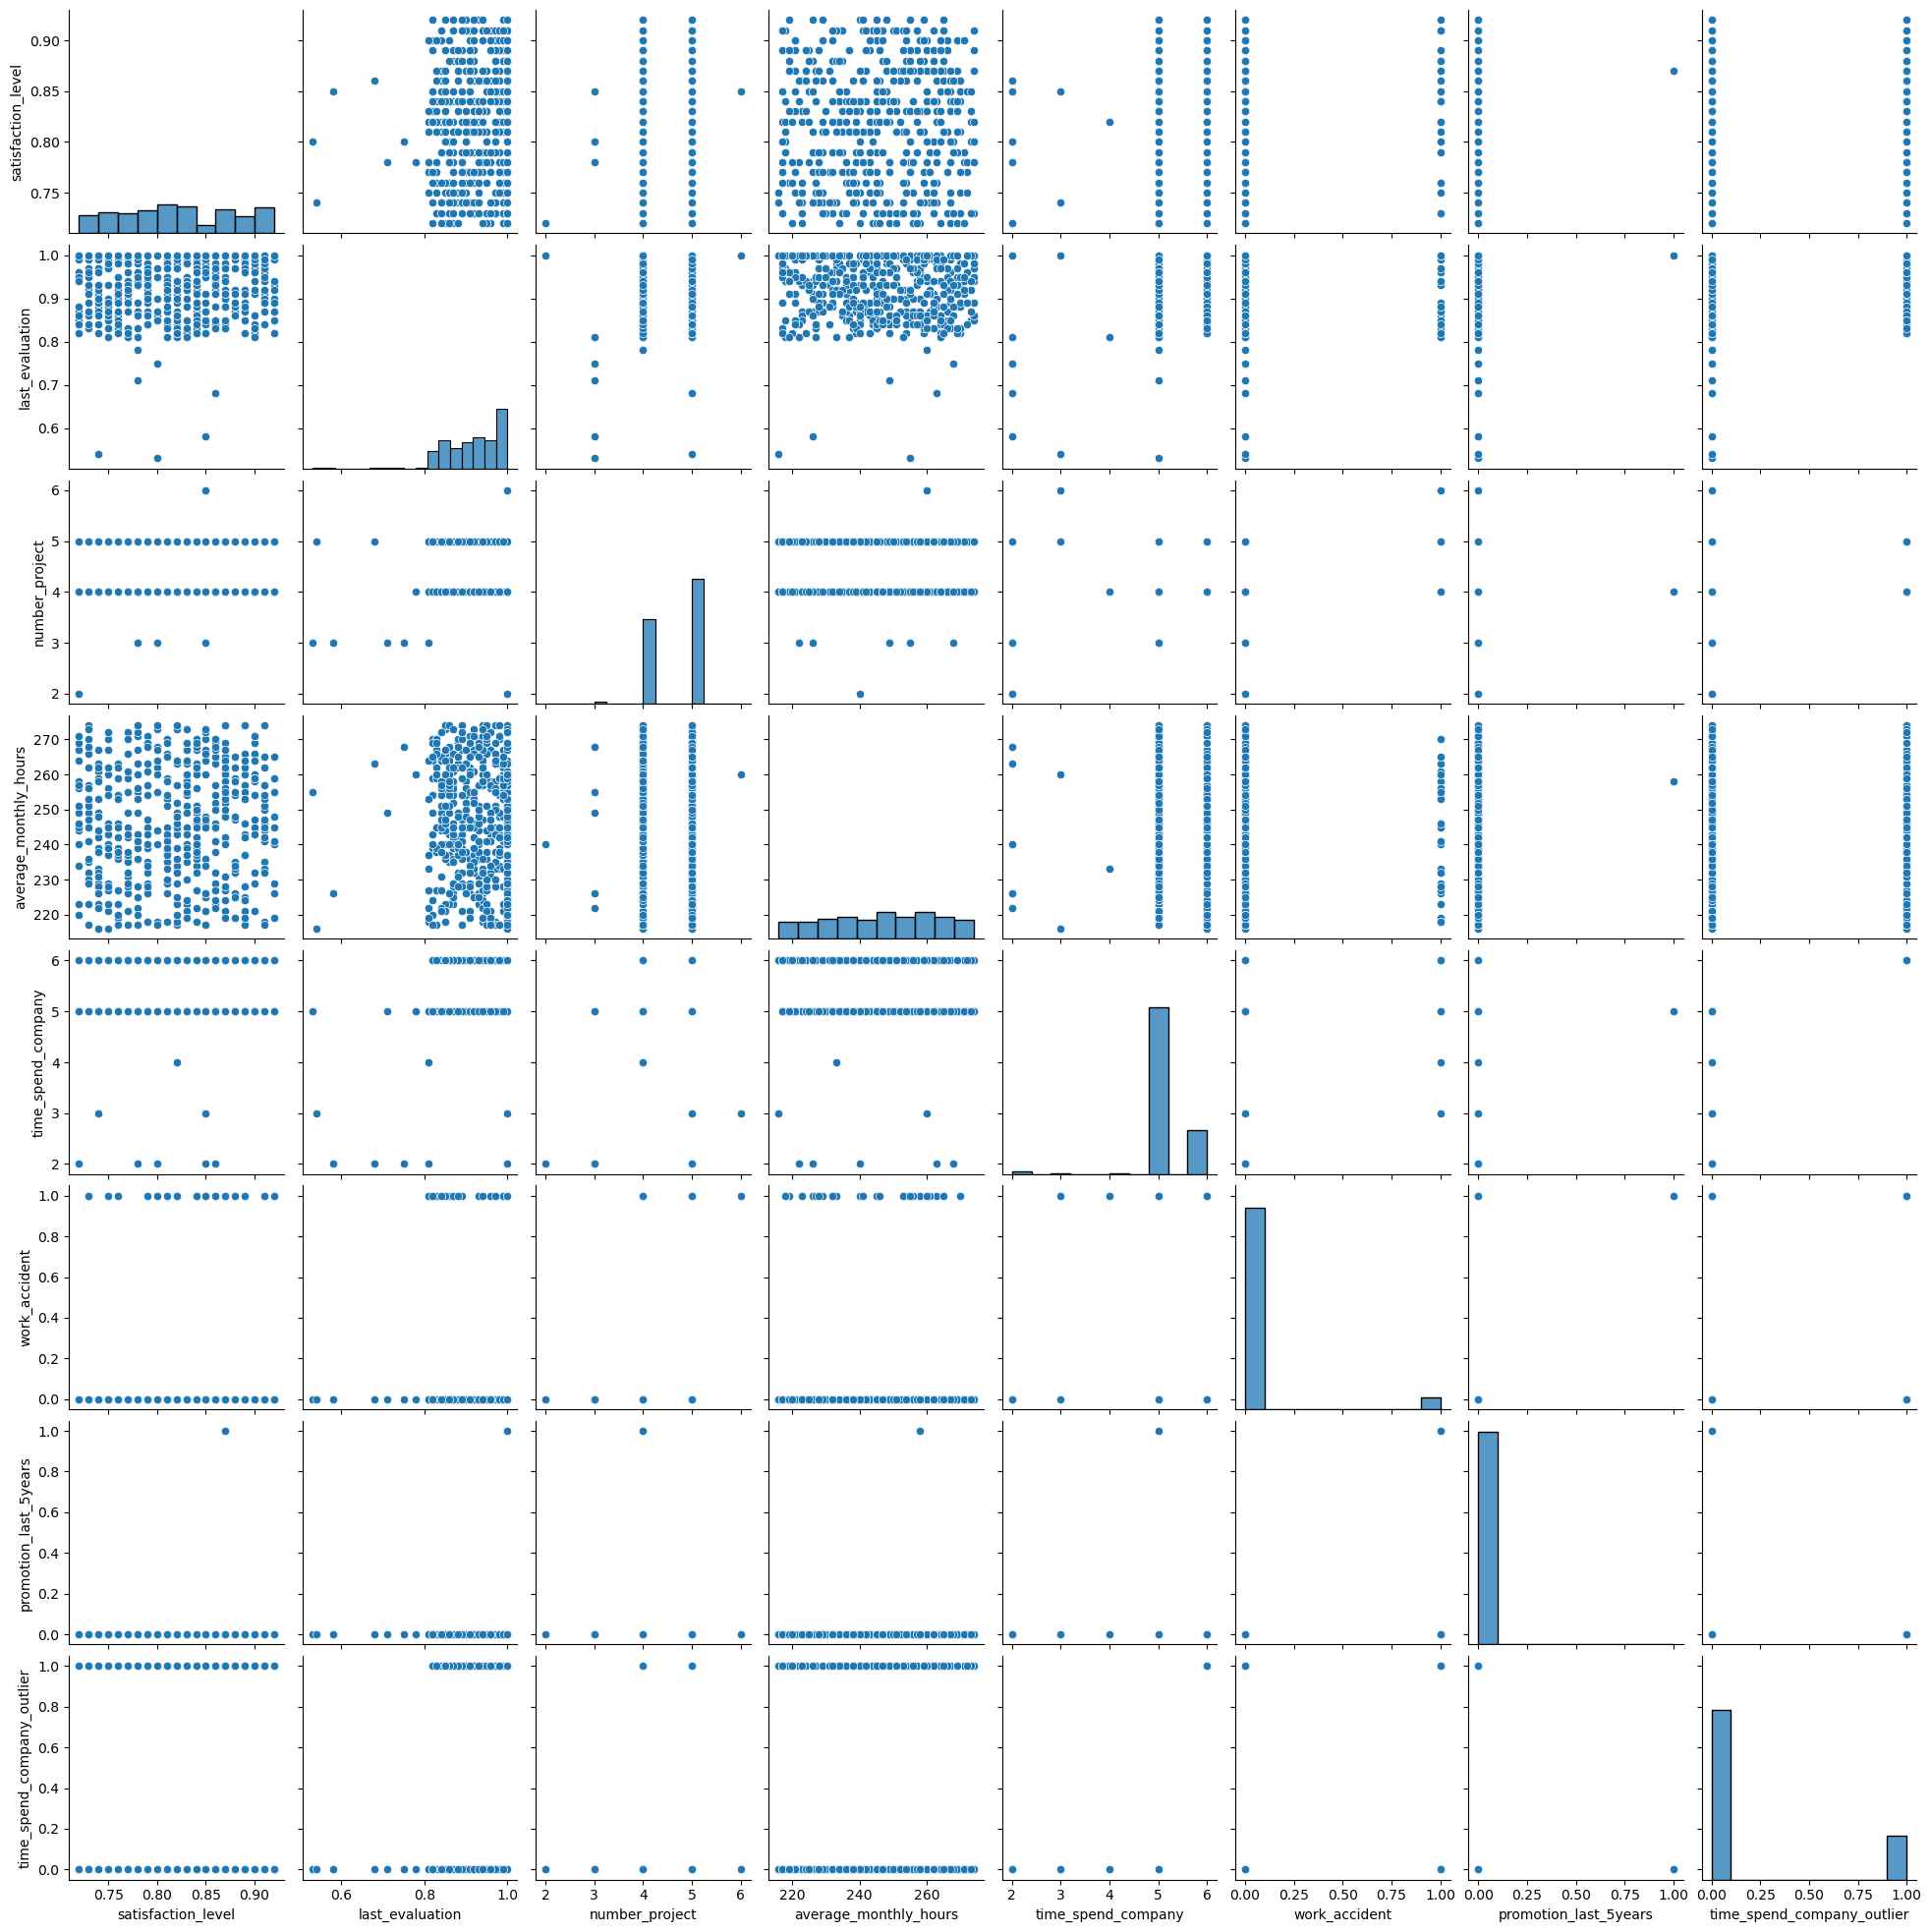

In [98]:
# look at the high satisfaction but left group
high_satisfaction_left = user_left[(user_left['satisfaction_level'] > 0.7)&(user_left['average_monthly_hours'] > 215)&(user_left['average_monthly_hours'] < 275)]
sns.pairplot(data=high_satisfaction_left)

**Time Spent at Company**
- Mostly 5 or 6 years

**Promotion Last 5 Years**
- No Promotions

This shows that if an employee who is satisfied at the company stays for 5 or more years and does not have a promotion, then they are likely to leave.

### What department are these employees mostly in?

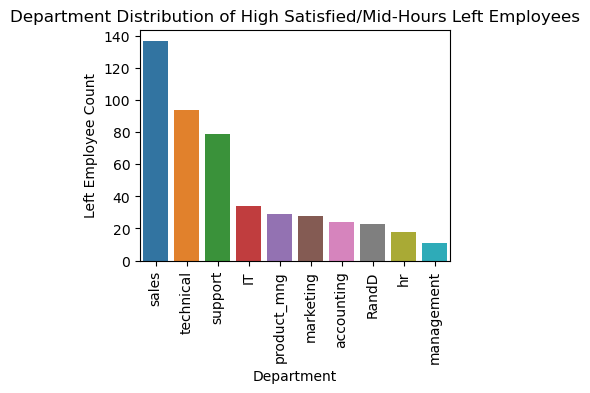

In [99]:
grouped_high_satisfaction_left = high_satisfaction_left['department'].value_counts().reset_index()
grouped_high_satisfaction_left.columns = ['department', 'employee_count']
plt.figure(figsize=(4, 3))
sns.barplot(data=grouped_high_satisfaction_left, x='department', y='employee_count')
plt.xticks(rotation=90)
plt.title('Department Distribution of High Satisfied/Mid-Hours Left Employees')
plt.xlabel('Department')
plt.ylabel('Left Employee Count')
plt.show()

### High Satisfaction and Mid-to-High Work hours Leaving Employees Analysis:
- This pair plot shows that they tend to fall into a category of:
    - Worked at the company 5 or more years
    - No Promotion in the last 5 years
    
- The Department Distribution is not overly represented by one department, so this looks to be a general trend among all departments.

## Feature Engineering

#### Create a Column that will indicate worked 5 years or more and did not get a promotion


In [100]:
# create a binary column using more than 4 years and no promotion
no_dupes_df['over_4yr_no_promo'] = no_dupes_df.apply(lambda row: 1 if (row['promotion_last_5years'] == 0)&(row['time_spend_company'] > 4) else 0, axis=1)

no_dupes_df.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours   
0                0.38             0.53               2                    157  \
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   time_spend_company  work_accident  left  promotion_last_5years department   
0                   3              0     1                      0      sales  \
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  time_spend_company_outlier  over_4yr_no_promo  
0     low                           0                  0  
1  medium                           1                  1  
2  medium                           0                  0  
3     low                           0                  1  
4     low                           0                  0

## Analyze Mid Satisfaction Low Hours + Low Projects Group that Left

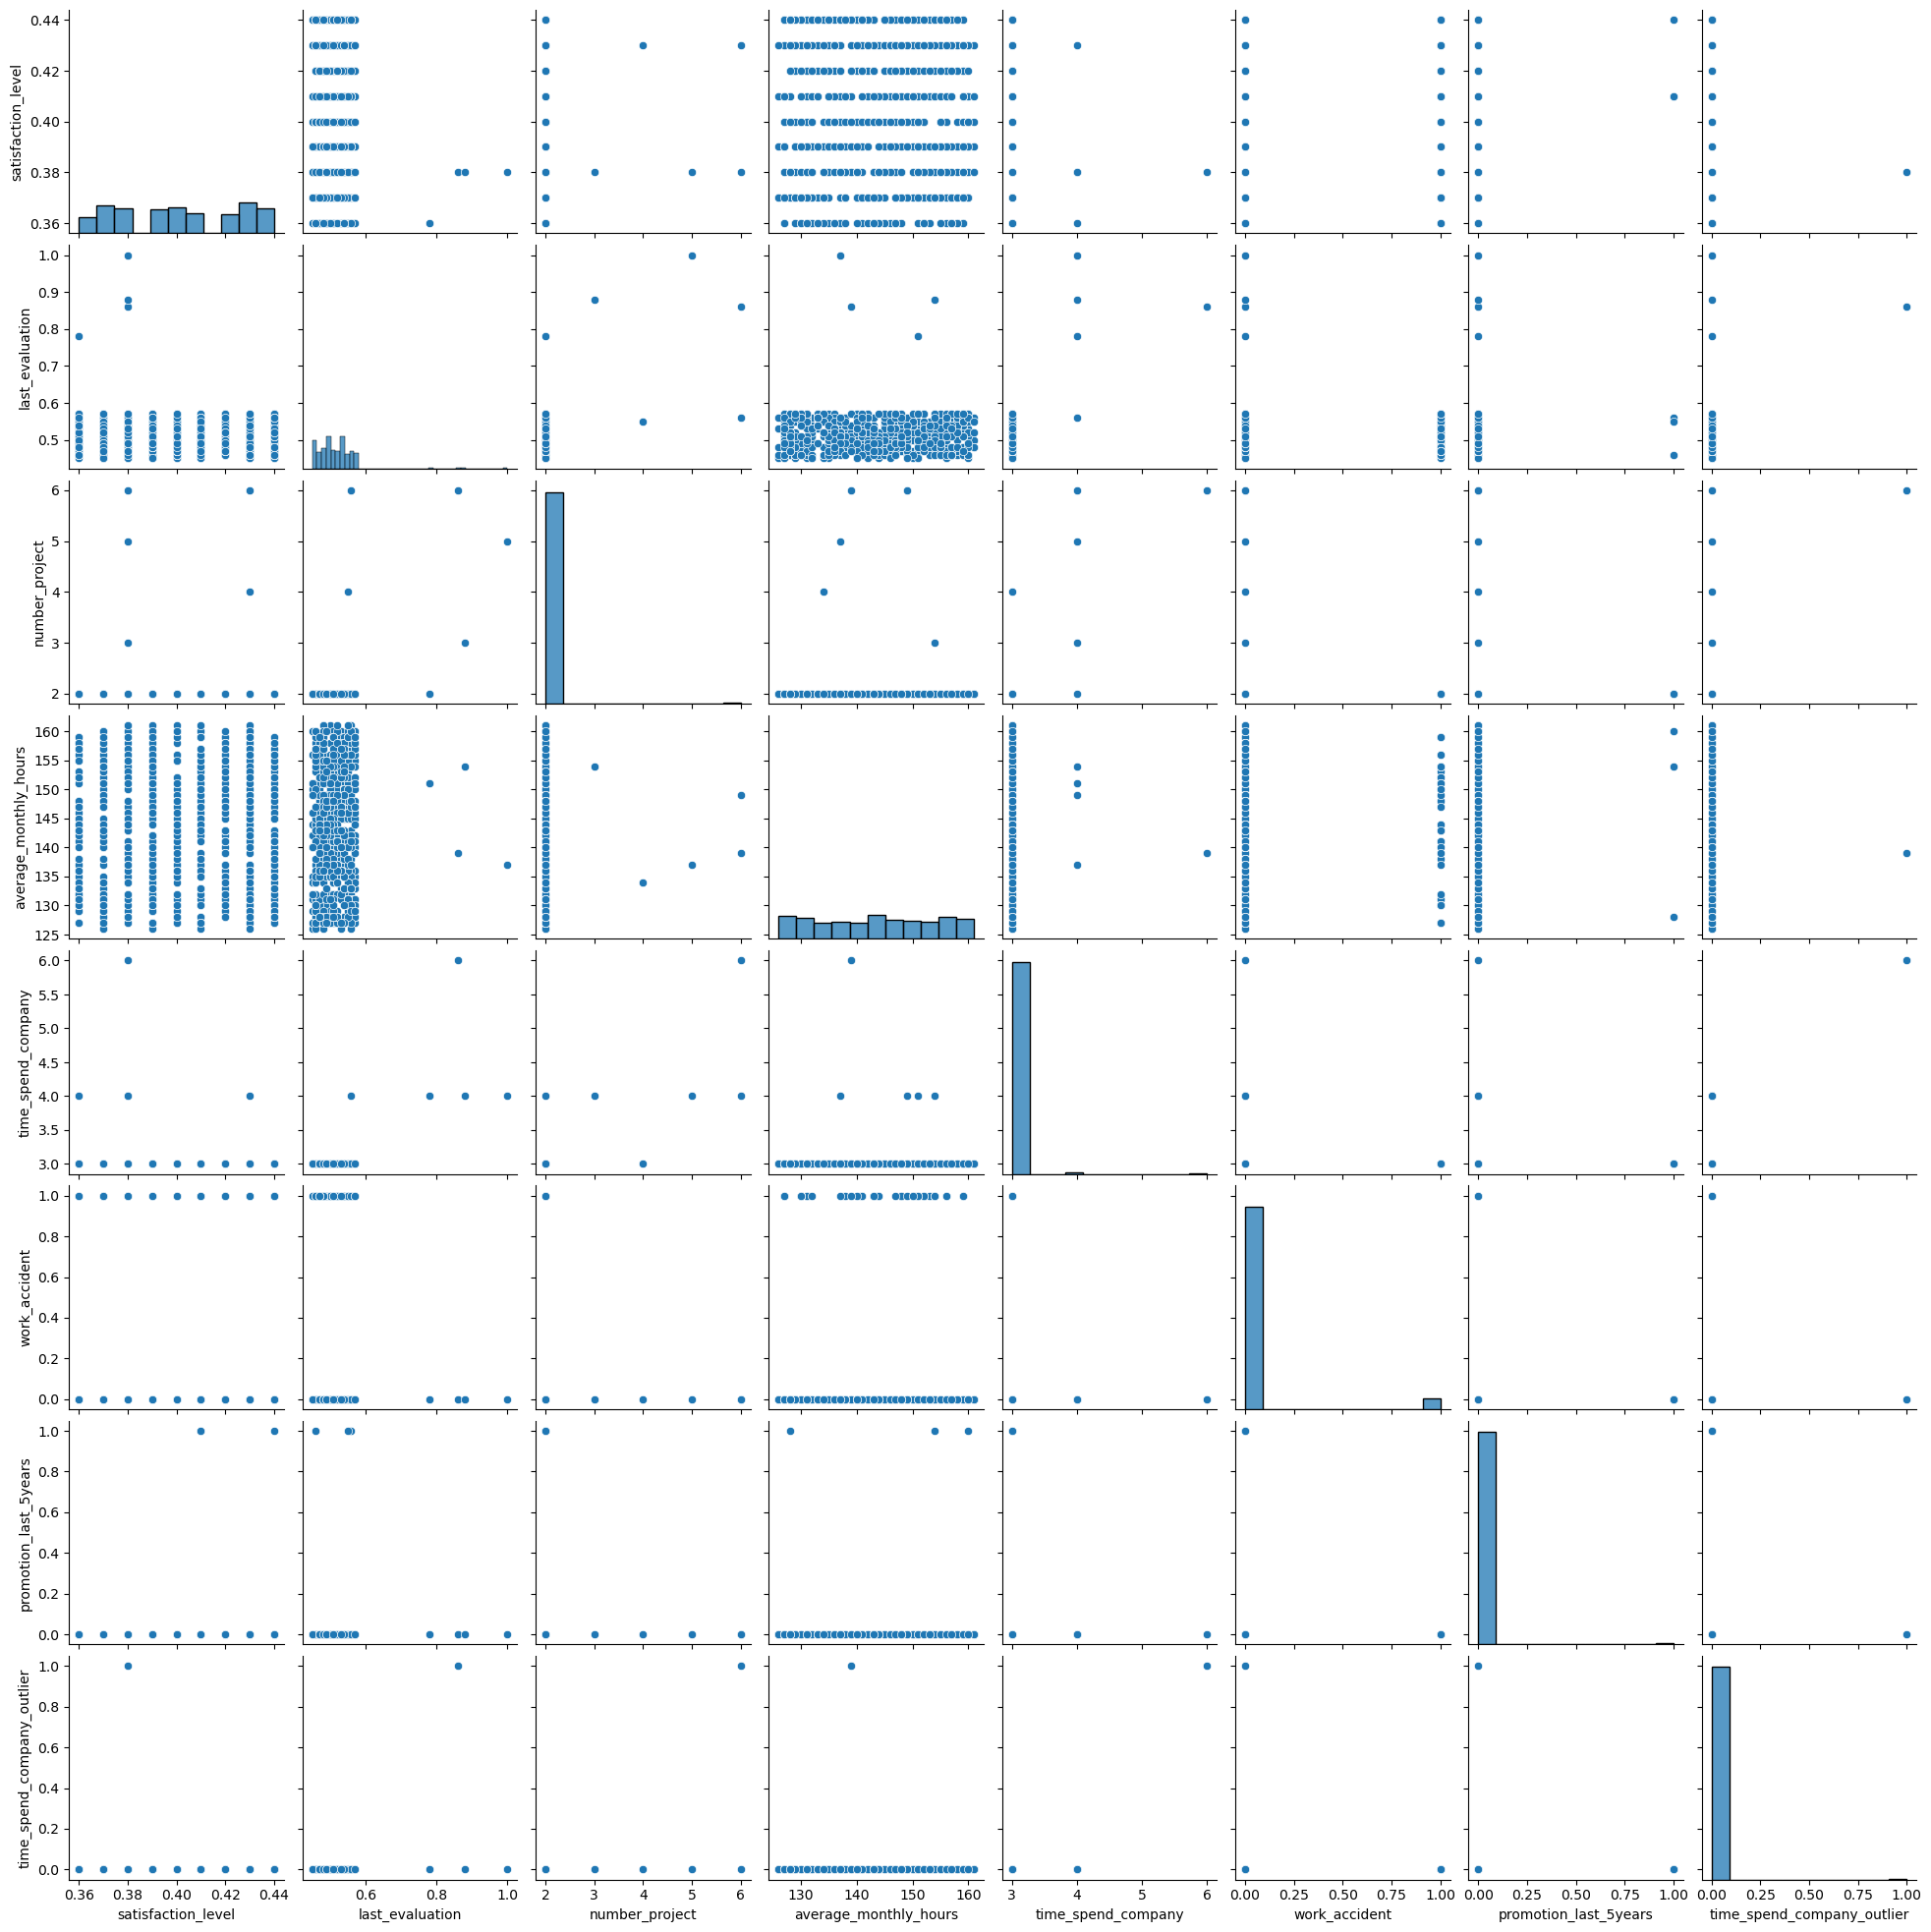

In [101]:
# look at the mid satisfaction but left group
mid_satisfaction_left = user_left[(user_left['satisfaction_level'] < 0.45)&(user_left['satisfaction_level'] > 0.35)&(user_left['average_monthly_hours'] > 125)&(user_left['average_monthly_hours'] < 165)]
sns.pairplot(data=mid_satisfaction_left)

### Mid-Satisfaction Group Analysis:
This group looks to have a fairly low last evaluation score on average and they are employees with a low numer of projects and who typically have only been at the company for three years.
- Low Evaluation Score
- Low Number of Projects
- Three Years at the Company

#### These employees are getting a low evaluation even though they do not seem to be overly worked. 
 - They might be either bored and thus underperforming and should have their project number increased. 
 - Or they might be employees with a poor work ethic and should be allowed to leave.

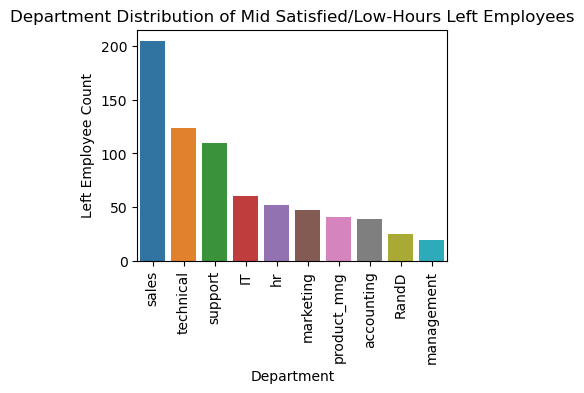

In [102]:
# what department are these employees mostly in
grouped_mid_satisfaction_left = mid_satisfaction_left['department'].value_counts().reset_index()
grouped_mid_satisfaction_left.columns = ['department', 'employee_count']
plt.figure(figsize=(4, 3))
sns.barplot(data=grouped_mid_satisfaction_left, x='department', y='employee_count')
plt.xticks(rotation=90)
plt.title('Department Distribution of Mid Satisfied/Low-Hours Left Employees')
plt.xlabel('Department')
plt.ylabel('Left Employee Count')
plt.show()

#### These employees are distributed between departments on a relatively equal scale to general employee distribution

## Analyze Low Satisfaction and High Work Hours Employees Left

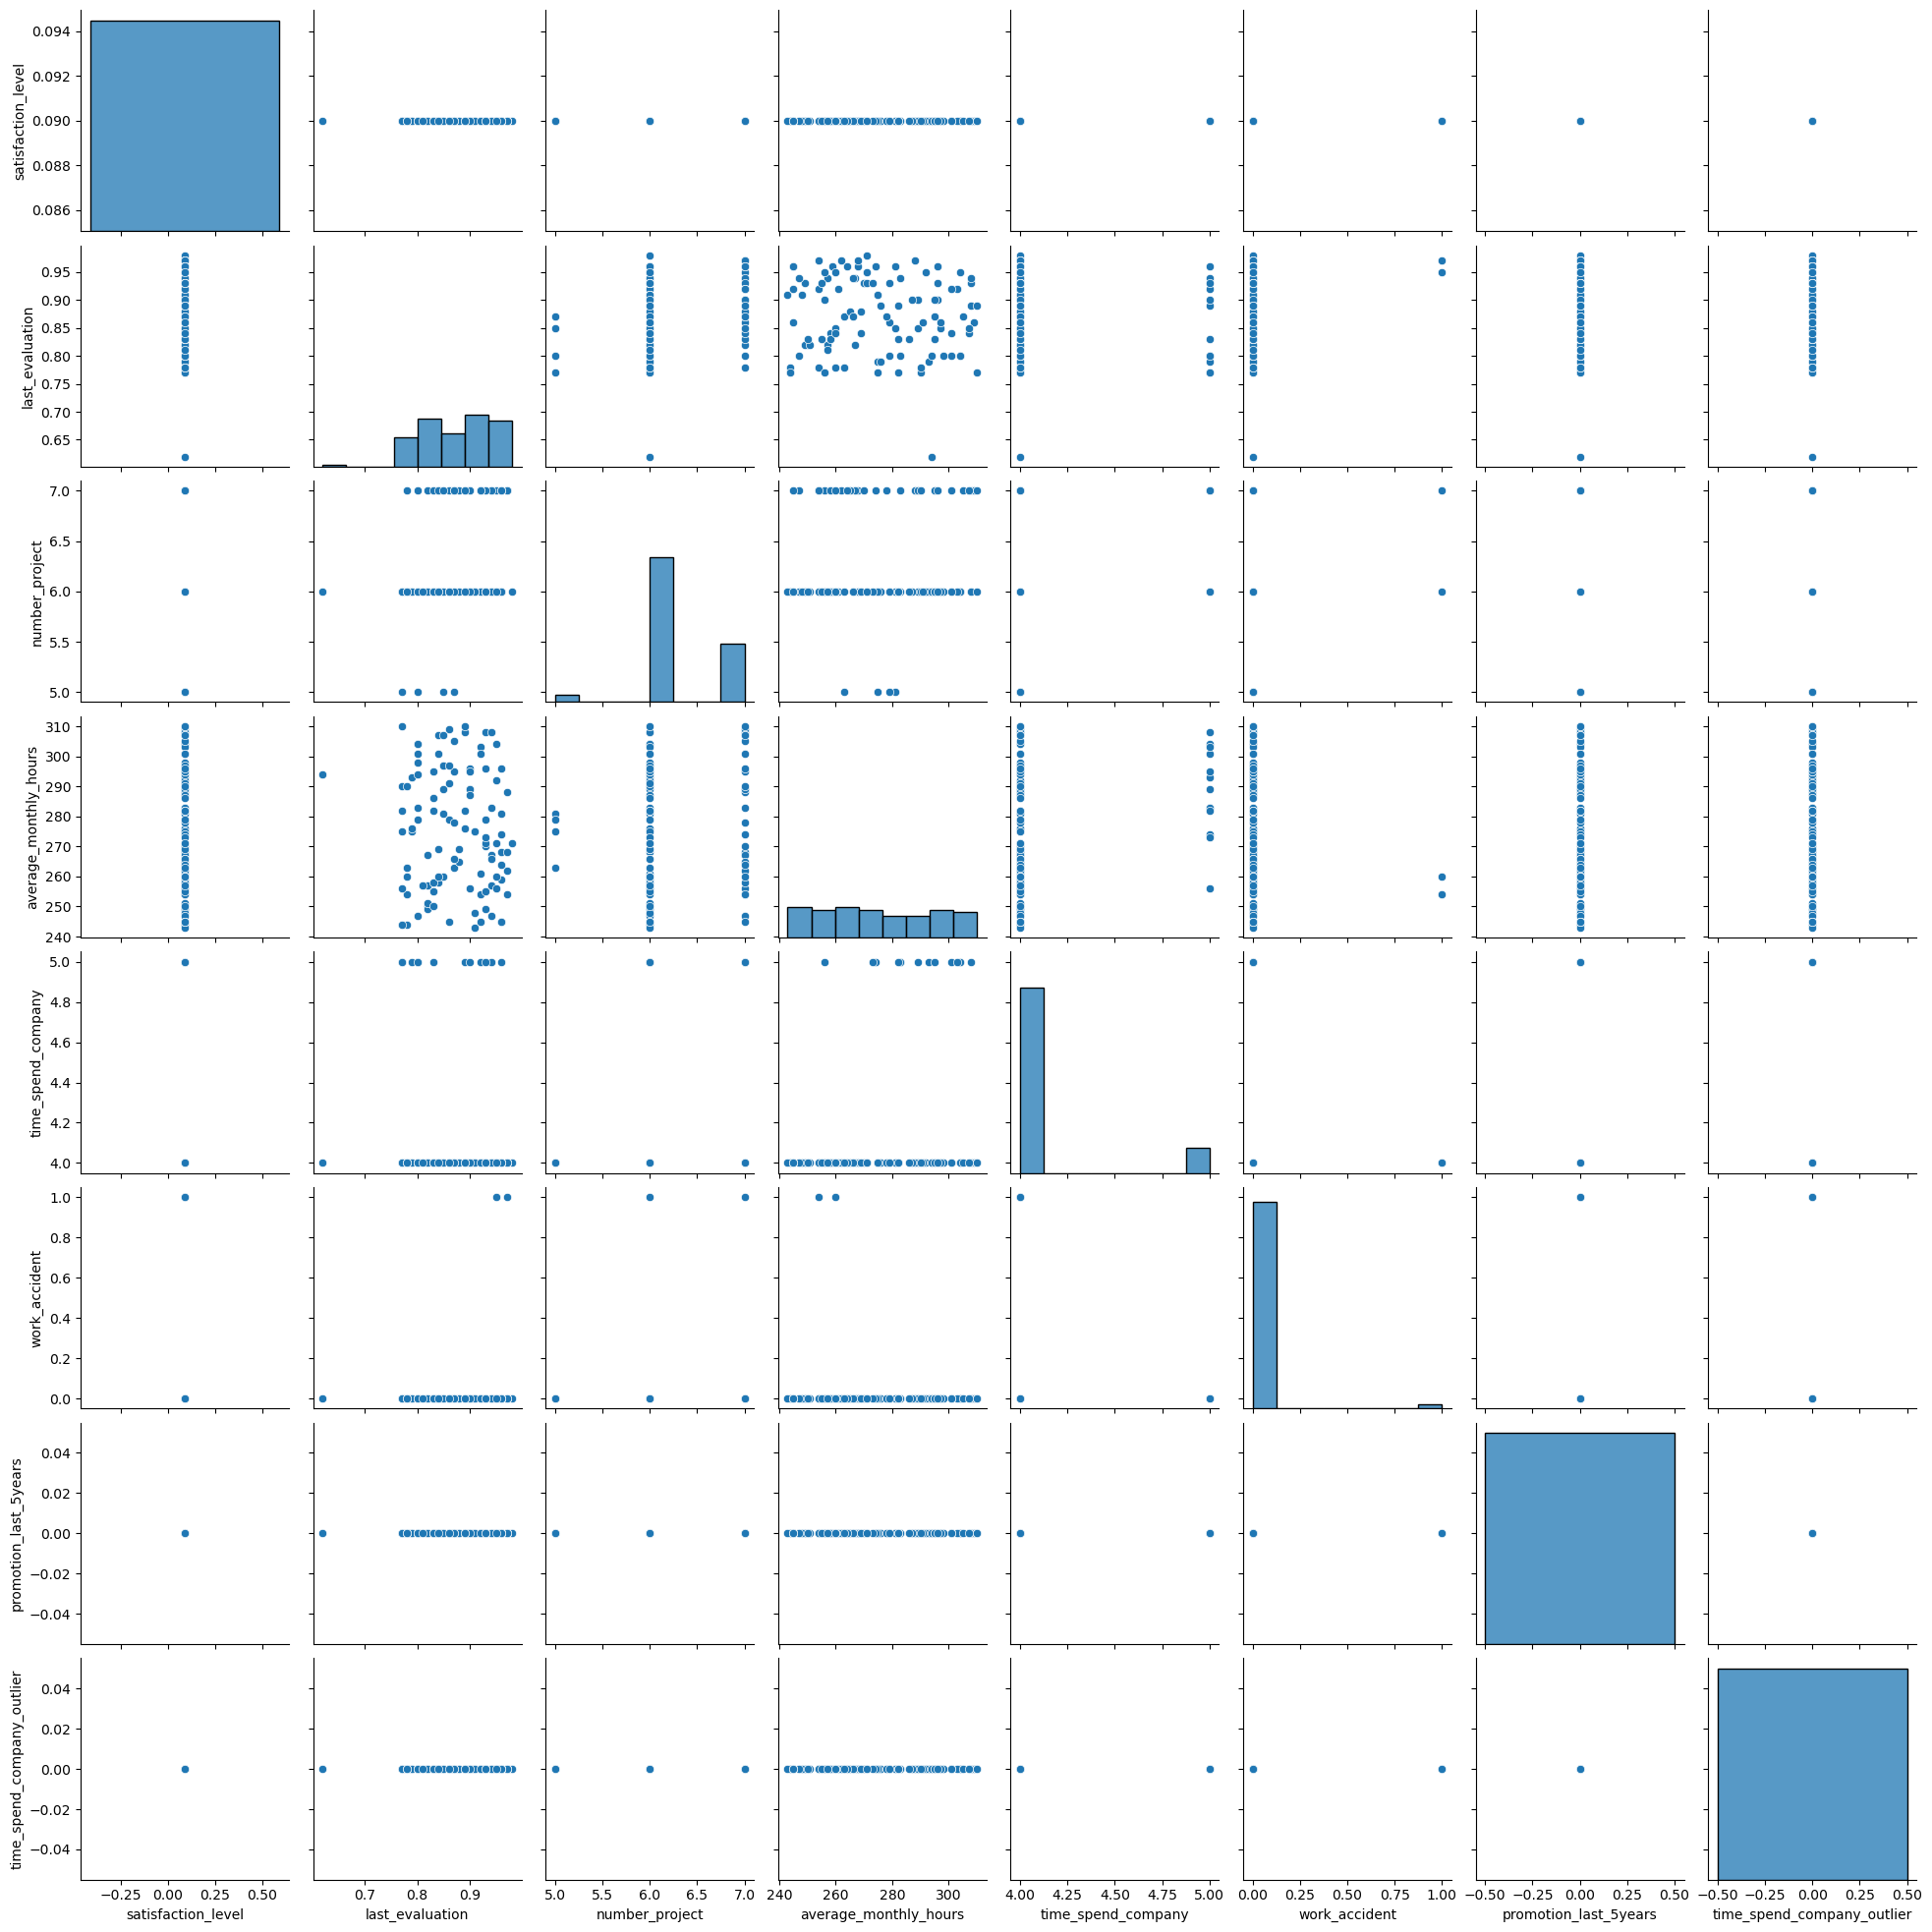

In [103]:
# look at the low satisfaction and left group
low_satisfaction_left = user_left[(user_left['satisfaction_level'] < 0.1)&(user_left['average_monthly_hours'] > 240)]
sns.pairplot(data=low_satisfaction_left)

### Low Satisfaction and High Hours Employees Left Analysis:
These employees high evaluation scores, but low satisfaction scores. As well, they typically have been at the company for 4 or 5 years and have not received a promotion. 
- High Evaluation Score
- Low Satisfaction Score
- 4 or 5 years
- No Promotion

## Valuable Insight:

#### This group should really be the focus of retention to since they perform at a high level but are likely not getting the promotion they deserve and also may be overly worked.

## Feature Engineering

Create a feature that captures the relationship between number of project, average houts, satisfaction, and last evaluation.

In [104]:
# create a column to try to capture the relationship between high evaluation and low satisfaction
no_dupes_df['over_worked_high_performer'] = no_dupes_df['number_project'] * no_dupes_df['average_monthly_hours'] * no_dupes_df['last_evaluation'] / no_dupes_df['satisfaction_level']
no_dupes_df.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours   
0                0.38             0.53               2                    157  \
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   time_spend_company  work_accident  left  promotion_last_5years department   
0                   3              0     1                      0      sales  \
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  time_spend_company_outlier  over_4yr_no_promo   
0     low                           0                  0  \
1  medium                           1                  1   
2  medium                           0                  0   
3     low                           0                  1   
4     low                           0                  0   

   over_worked_high_performer  
0                  437.947368  
1                 1408.250000  
2                15232.000000  
3                 1347.291667  
4                  446.918919

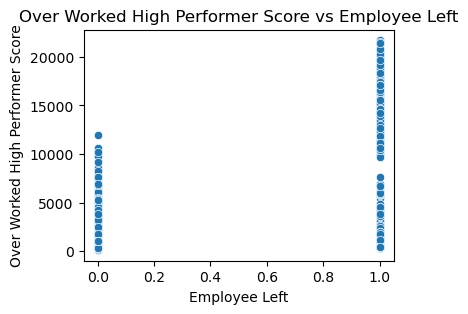

In [105]:
plt.figure(figsize=(4, 3))
sns.scatterplot(data=no_dupes_df, x='left', y='over_worked_high_performer')
plt.title('Over Worked High Performer Score vs Employee Left')
plt.xlabel('Employee Left')
plt.ylabel('Over Worked High Performer Score')
plt.show()

#### Here there is a score that seems to almost signify the limit that signals over worked high performer likely to leave, if greater than 10000 then it seems very likely.

# Insights

### General Guidelines:
- Employees with **more than 6 projects** tend to leave
- Employees with **average monthly hours above ~275** tend to leave.
- Employees who have a **satisfaction level at or below 0.1** tend to leave.

### There are three main groups of Employees who leave:
- **High Satisfaction Employees who are Mid-Level Performers**:
    - They typically leave because they have been at the company for greater than 5 years and have not had a promotion
    
- **Mid Satisfaction Employees who are Under Perfomers**:
    - They typically have few projects, work below the average number of hours and are 3 years or less at the company.
    
- **Low Satisfaction Employees who are Over Performers**:
    - They have many projects, work high average number of yours and are at 4 or 5 years tenure, but have not recieved a promotion.
    
   

### Final View of Features and Target on Correlation Matrix

In [106]:
num_cols = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company', 'over_worked_high_performer']
cat_cols = ['salary', 'department', 'over_4yr_no_promo']

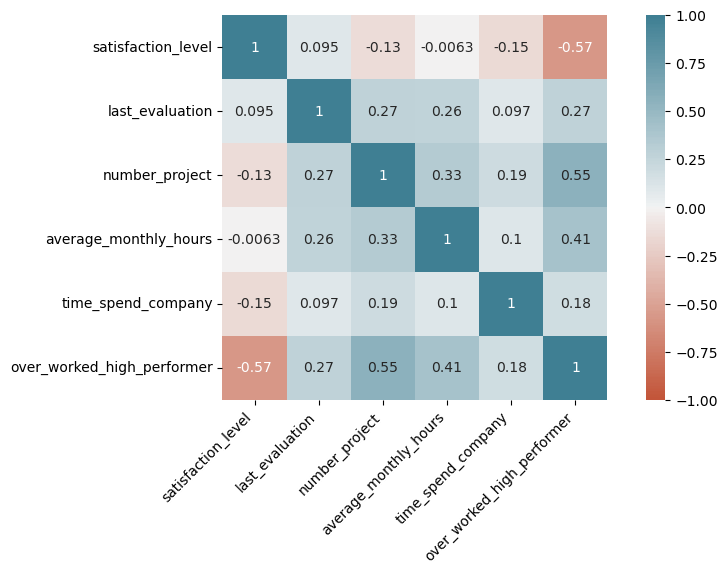

In [107]:
# check the colinearity of the final features
final_corr = no_dupes_df[num_cols].corr()
plt.figure(figsize=(10, 5))
ax = sns.heatmap(
    final_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show()

# Construct Stage
- Determine which models are most appropriate
- Construct the model
- Confirm model assumptions
- Evaluate model results to determine how well your model fits the data


### Type of prediction task

This is a binary classification task. The model can return a probability for the strength of the classification and that can be used to better understand which employees to focus on attending to first.

From the EDA, the relationship between the features and the target is **not a linear relationship** and thus I will **exclude Logistic Regression** from the modeling.

### Identify the types of models most appropriate for this task.

From this course, the types of models that seem appropriate are:

- Random Forest
- XGBoost
- Naive Bayes

# Modeling

## Random Forest Default with all Features

Use default hyperparameters and all of the features for the first round of analysis. The Random Forest automatically does feature selection based and the categorical features do not need to be one hot encoded. As well, the Random Forest is immune to outliers and thus they do not need to be removed.

In [108]:
# create X and y arrays 
X = no_dupes_df.drop(columns=['left'])
y = no_dupes_df['left']

# create dummy variables
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# write the X columns to a json file
X_cols = X.columns.tolist()
with open('../models/model_cols.json', 'w') as f:
    json.dump(X_cols, f)

# view the columns and the data is all numeric
X.info()


<class 'pandas.core.frame.DataFrame'>
Index: 11991 entries, 0 to 11999
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   satisfaction_level          11991 non-null  float64
 1   last_evaluation             11991 non-null  float64
 2   number_project              11991 non-null  int64  
 3   average_monthly_hours       11991 non-null  int64  
 4   time_spend_company          11991 non-null  int64  
 5   work_accident               11991 non-null  int64  
 6   promotion_last_5years       11991 non-null  int64  
 7   time_spend_company_outlier  11991 non-null  int64  
 8   over_worked_high_performer  11991 non-null  float64
 9   salary_low                  11991 non-null  bool   
 10  salary_medium               11991 non-null  bool   
 11  department_RandD            11991 non-null  bool   
 12  department_accounting       11991 non-null  bool   
 13  department_hr               11991 no

In [109]:
# split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [110]:
# instantiate the Random Forest Model
rf_clf = RandomForestClassifier()


scores = cross_validate(rf_clf, 
                        X_train, 
                        y_train, 
                        cv=5, 
                        scoring=('f1', 'roc_auc', 'precision', 'recall'), 
                        return_train_score=True)

print('Random Forest Default Hyperparameters Results\n')
print('CV Test Results:')
print('\tF1 Score:', round(np.mean(scores['test_f1']), 3))
print('\tROC-AUC Score:', round(np.mean(scores['test_roc_auc']), 3))
print('\tPrecision Score:', round(np.mean(scores['test_precision']), 3))
print('\tRecall Score:', round(np.mean(scores['test_recall']), 3))



Random Forest Default Hyperparameters Results

CV Test Results:
	F1 Score: 0.943
	ROC-AUC Score: 0.981
	Precision Score: 0.983
	Recall Score: 0.907


In [111]:
# create a dataframe to store the model results
model_results = pd.DataFrame(columns=['model', 'f1', 'roc_auc', 'precision', 'recall'])
# store results in the dataframe
model_results = pd.concat([model_results, pd.DataFrame([{'model':'Random Forest Default CV',
                                                         'f1':round(np.mean(scores['test_f1']), 3),
                                                         'roc_auc':round(np.mean(scores['test_roc_auc']), 3),
                                                         'precision':round(np.mean(scores['test_precision']), 3),
                                                         'recall':round(np.mean(scores['test_recall']), 3)}])], ignore_index=True)

model_results

model     f1  roc_auc  precision  recall
0  Random Forest Default CV  0.943    0.981      0.983   0.907

In [112]:
# fit the default model on the training data
rf_clf.fit(X_train, y_train)

# test the best model on the test data
y_preds = rf_clf.predict(X_test)

# calculate f1
recall = recall_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
f1 = 2 * (recall * precision) / (recall + precision) 

# view the evaluation metrics
print('Default Random Forest Model')
print('\nTest Set Results:')
print('F1:', round(f1, 3))
print('ROC-AUC:', round(roc_auc_score(y_test, y_preds), 3))
print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))

Default Random Forest Model

Test Set Results:
F1: 0.954
ROC-AUC: 0.961
Precision: 0.986
Recall: 0.925


## XGBoost Default with all Features

Use default hyperparameters and all of the features for the first round of analysis. XGBoost automatically does feature selection based and the categorical features do not need to be one hot encoded. As well, XGBoost is immune to outliers and thus they do not need to be removed.

In [113]:
# instantiate the XGBoost Model
xgb_clf = XGBClassifier()


scores = cross_validate(xgb_clf, 
                        X_train, 
                        y_train, 
                        cv=5, 
                        scoring=('f1', 'roc_auc', 'precision', 'recall'), 
                        return_train_score=True)

print('XGBoost Default Hyperparameters Results\n')
print('CV Test Results:')
print('\tF1 Score:', round(np.mean(scores['test_f1']), 3))
print('\tROC-AUC Score:', round(np.mean(scores['test_roc_auc']), 3))
print('\tPrecision Score:', round(np.mean(scores['test_precision']), 3))
print('\tRecall Score:', round(np.mean(scores['test_recall']), 3))

XGBoost Default Hyperparameters Results

CV Test Results:
	F1 Score: 0.943
	ROC-AUC Score: 0.982
	Precision Score: 0.97
	Recall Score: 0.918


In [114]:
# fit the default model on the training data
xgb_clf.fit(X_train, y_train)

# test the best model on the test data
y_preds = xgb_clf.predict(X_test)

# calculate f1
recall = recall_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
f1 = 2 * (recall * precision) / (recall + precision) 

# view the evaluation metrics
print('Default XGBoost Model')
print('\nTest Set Results:')
print('F1:', round(f1, 3))
print('ROC-AUC:', round(roc_auc_score(y_test, y_preds), 3))
print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))

Default XGBoost Model

Test Set Results:
F1: 0.947
ROC-AUC: 0.96
Precision: 0.968
Recall: 0.926


In [115]:
# add the default XGBoost results to the model results dataframe
model_results = pd.concat([model_results, pd.DataFrame([{'model':'XGBoost Default CV',
                                                         'f1':round(np.mean(scores['test_f1']), 3),
                                                         'roc_auc':round(np.mean(scores['test_roc_auc']), 3),
                                                         'precision':round(np.mean(scores['test_precision']), 3),
                                                         'recall':round(np.mean(scores['test_recall']), 3)}])], ignore_index=True)

### Random Forest Hyperparameter Tuning

In [116]:
# split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# save the test sets for the final model
final_X_test = X_test.copy()
final_y_test = y_test.copy()

# view the shapes of the data
X_train.shape, X_test.shape

((8993, 21), (2998, 21))

In [117]:
# create the hyperparameters search space
cv_params = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(120, 800),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'min_samples_split': uniform(0.01, 0.199),
    # randomly sample numbers from 5 to 30
    'max_depth':randint(5,30),
    # categoricaly choose between balanced and imbalanced
    'class_weight':['balanced', None]
    }


# define the scoring params
scoring = ['f1', 'precision', 'recall', 'roc_auc']

split_index = [0 if x in X_val.index else -1 for x in X_train.index]
custom_split = PredefinedSplit(split_index)

In [118]:
# create the Random Search CV
rf_cv = RandomizedSearchCV(rf_clf, cv_params, n_iter=50, scoring=scoring, refit='f1', n_jobs=-1, cv=custom_split, random_state=42)

In [119]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 4.17 s
Wall time: 44 s


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([ 0, -1, ..., -1, -1])),
                   estimator=RandomForestClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C02DA1BE80>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C02D9F6B60>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C02D9F7CD0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C01C5C93F0>},
                   random_state=42, refit='f1',
                   scoring=['f1', 'precision', 'recall', 'roc_auc'])

In [120]:
rf_cv.best_params_

{'class_weight': 'balanced',
 'max_depth': 29,
 'max_features': 0.3086069575737274,
 'min_samples_split': 0.010103555022067848,
 'n_estimators': 378}

In [121]:
rf_f1 = rf_cv.cv_results_['mean_test_f1'][rf_cv.best_index_]
rf_roc_auc = rf_cv.cv_results_['mean_test_roc_auc'][rf_cv.best_index_]
rf_prec = rf_cv.cv_results_['mean_test_precision'][rf_cv.best_index_]
rf_rec = rf_cv.cv_results_['mean_test_recall'][rf_cv.best_index_]


print('Random Forest Tuned Hyperparameters Results\n')
print('CV Results:')
print('\tF1 Score:', round(rf_f1, 3))
print('\tROC-AUC Score:', round(rf_roc_auc, 3))
print('\tPrecision Score:', round(rf_prec, 3))
print('\tRecall Score:', round(rf_rec, 3))

Random Forest Tuned Hyperparameters Results

CV Results:
	F1 Score: 0.95
	ROC-AUC Score: 0.984
	Precision Score: 0.983
	Recall Score: 0.92


In [122]:
# add the tuned Random Forest results to the model results dataframe
temp_df = pd.DataFrame([{'model':'Random Forest Tuned CV',
                        'f1':round(rf_f1, 3),
                        'roc_auc':round(rf_roc_auc, 3),
                        'precision':round(rf_prec, 3),
                        'recall':round(rf_rec, 3)}])
model_results = pd.concat([model_results, temp_df], ignore_index=True)
model_results

model     f1  roc_auc  precision  recall
0  Random Forest Default CV  0.943    0.981      0.983   0.907
1        XGBoost Default CV  0.943    0.982      0.970   0.918
2    Random Forest Tuned CV  0.950    0.984      0.983   0.920

In [123]:
# test the best model on the test data
rf_best = rf_cv.best_estimator_

rf_best.fit(X_train, y_train)

y_preds = rf_best.predict(X_test)

# calculate f1
recall = recall_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
f1 = 2 * (recall * precision) / (recall + precision) 

# view the evaluation metrics
print('Best Hyperparameter Tuned Random Forest Model')
print('\nTest Results:')
print('F1:', round(f1, 3))
print('ROC-AUC:', round(roc_auc_score(y_test, y_preds), 3))
print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))


Best Hyperparameter Tuned Random Forest Model

Test Results:
F1: 0.958
ROC-AUC: 0.963
Precision: 0.989
Recall: 0.928


## XGBoost Hyperparameter Tuning

In [124]:
# create the hyperparameters search space
cv_params = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(120, 800),
    # randomly sample from 0.01 to 0.1 learning rate
    'eta': uniform(0.01, 0.1),
    # randomly sample from 3 to 25 for max depth
    'max_depth': randint(3, 25),
    # randomly sample from 1 to 7 for min child weight
    'min_child_weight':randint(1, 7),
    # randomly sample from 0.6 to 1.0 for subsample
    'subsample':uniform(0.6, 1.0),
    # randomly choose weight for positive class between 1 and 4
    'scale_pos_weight':randint(1, 4)
    }


# define the scoring params
scoring = ['f1', 'precision', 'recall', 'roc_auc']

split_index = [0 if x in X_val.index else -1 for x in X_train.index]
custom_split = PredefinedSplit(split_index)

In [125]:
xgb_cv = RandomizedSearchCV(xgb_clf, cv_params, n_iter=50, scoring=scoring, refit='f1', n_jobs=-1, cv=custom_split, random_state=42)

In [126]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 2.19 s
Wall time: 7.08 s


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([ 0, -1, ..., -1, -1])),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_typ...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C02D9F51B0>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C02DAFDB10>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C02DAFF580>},
                   random_state=42, refit='f1',
                   scoring=['f1', 'precision', 'recall', 'roc_auc'])

In [127]:
xgb_f1 = xgb_cv.cv_results_['mean_test_f1'][xgb_cv.best_index_]
xgb_roc_auc = xgb_cv.cv_results_['mean_test_roc_auc'][xgb_cv.best_index_]
xgb_prec = xgb_cv.cv_results_['mean_test_precision'][xgb_cv.best_index_]
xgb_rec = xgb_cv.cv_results_['mean_test_recall'][xgb_cv.best_index_]


print('XGBoost Tuned Hyperparameters Results\n')
print('CV Results:')
print('\tF1 Score:', round(xgb_f1, 3))
print('\tROC-AUC Score:', round(xgb_roc_auc, 3))
print('\tPrecision Score:', round(xgb_prec, 3))
print('\tRecall Score:', round(xgb_rec, 3))

XGBoost Tuned Hyperparameters Results

CV Results:
	F1 Score: 0.959
	ROC-AUC Score: 0.984
	Precision Score: 0.986
	Recall Score: 0.933


In [128]:
# add the tuned XGBoost results to the model results dataframe
temp_df = pd.DataFrame([{'model':'XGBoost Tuned CV',
                        'f1':round(xgb_f1, 3),
                        'roc_auc':round(xgb_roc_auc, 3),
                        'precision':round(xgb_prec, 3),
                        'recall':round(xgb_rec, 3)}])
model_results = pd.concat([model_results, temp_df], ignore_index=True)
model_results

model     f1  roc_auc  precision  recall
0  Random Forest Default CV  0.943    0.981      0.983   0.907
1        XGBoost Default CV  0.943    0.982      0.970   0.918
2    Random Forest Tuned CV  0.950    0.984      0.983   0.920
3          XGBoost Tuned CV  0.959    0.984      0.986   0.933

In [129]:
xgb_cv.best_params_

{'eta': 0.0916431873219384,
 'max_depth': 18,
 'min_child_weight': 1,
 'n_estimators': 320,
 'scale_pos_weight': 3,
 'subsample': 0.7865185103998542}

In [130]:
# test the best model on the test data
xgb_best = xgb_cv.best_estimator_

xgb_best.fit(X_train, y_train)

y_preds = xgb_best.predict(X_test)

# calculate f1
recall = recall_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
f1 = 2 * (recall * precision) / (recall + precision) 

# view the evaluation metrics
print('Best Hyperparameter XGBoost Model')
print('\nTest Results:')
print('F1:', round(f1, 3))
print('ROC-AUC:', round(roc_auc_score(y_test, y_preds), 3))
print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))


Best Hyperparameter XGBoost Model

Test Results:
F1: 0.95
ROC-AUC: 0.96
Precision: 0.975
Recall: 0.926


# Execute Stage
- Interpret model performance and results
- Share actionable steps with stakeholders



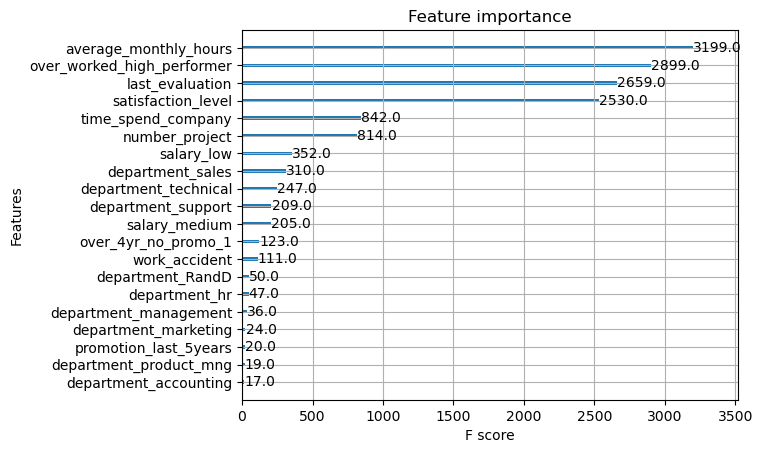

In [131]:
plot_importance(xgb_best)
plt.show()

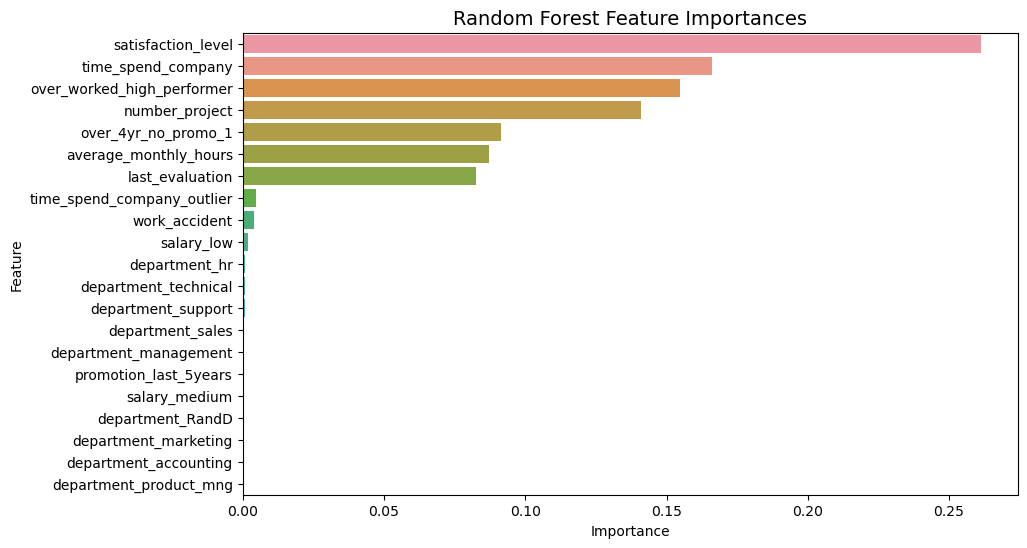

In [132]:
importances = rf_best.feature_importances_
feature_names = X_train.columns
feat_imps = {}
for i, name in enumerate(feature_names):
    feat_imps[name] = importances[i]
    
feat_imps_df = pd.DataFrame([feat_imps]).T.reset_index()
feat_imps_df.columns = ['feature', 'importance']
feat_imps_df = feat_imps_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imps_df, x='importance', y='feature')
plt.title('Random Forest Feature Importances', fontsize=14)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Features to Possibly Remove:
- **Department**
- **Promotion Last 5 Years** (Since it is mostly indicated in the over_4yr_no_promo column)

## Try the modeling with these two features removed for Random Forest

In [133]:
# drop all department columns and the promotion_last_5years
drop_cols = [col for col in X.columns if 'department' in col] + ['promotion_last_5years']
X = X.drop(columns=drop_cols)

# sanity check that the columns were dropped
assert 'promotion_last_5years' not in X.columns
assert len([col for col in X.columns if 'department' in col]) == 0

# split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)



In [134]:
# create the hyperparameters search space
cv_params = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(120, 800),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'min_samples_split': uniform(0.01, 0.199),
    # randomly sample numbers from 5 to 30
    'max_depth':randint(5,30),
    # categoricaly choose between balanced and imbalanced
    'class_weight':['balanced', None]
    }


# define the scoring params
scoring = ['f1', 'precision', 'recall', 'roc_auc']

split_index = [0 if x in X_val.index else -1 for x in X_train.index]
custom_split = PredefinedSplit(split_index)

In [135]:
rf_drop_cv = RandomizedSearchCV(rf_clf, cv_params, n_iter=50, scoring=scoring, refit='f1', n_jobs=-1, cv=custom_split, random_state=42)

In [136]:
%%time
rf_drop_cv.fit(X_train, y_train)

CPU times: total: 3.41 s
Wall time: 40.9 s


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([ 0, -1, ..., -1, -1])),
                   estimator=RandomForestClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C0290CFEB0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C01AD31780>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C01AD316C0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C02C9E48E0>},
                   random_state=42, refit='f1',
                   scoring=['f1', 'precision', 'recall', 'roc_auc'])

In [137]:
rf_f1 = rf_drop_cv.cv_results_['mean_test_f1'][rf_drop_cv.best_index_]
rf_roc_auc = rf_drop_cv.cv_results_['mean_test_roc_auc'][rf_drop_cv.best_index_]
rf_prec = rf_drop_cv.cv_results_['mean_test_precision'][rf_drop_cv.best_index_]
rf_rec = rf_drop_cv.cv_results_['mean_test_recall'][rf_drop_cv.best_index_]


print('Random Forest Dropped Feats Tuned Hyperparameters Results\n')
print('CV Results:')
print('\tF1 Score:', round(rf_f1, 3))
print('\tROC-AUC Score:', round(rf_roc_auc, 3))
print('\tPrecision Score:', round(rf_prec, 3))
print('\tRecall Score:', round(rf_rec, 3))

Random Forest Dropped Feats Tuned Hyperparameters Results

CV Results:
	F1 Score: 0.95
	ROC-AUC Score: 0.984
	Precision Score: 0.983
	Recall Score: 0.92


In [138]:
# add the tuned Random Forest dropped feautures results to the model results dataframe
temp_df = pd.DataFrame([{'model':'Random Forest Dropped Feats Tuned CV',
                        'f1':round(rf_f1, 3),
                        'roc_auc':round(rf_roc_auc, 3),
                        'precision':round(rf_prec, 3),
                        'recall':round(rf_rec, 3)}])
model_results = pd.concat([model_results, temp_df], ignore_index=True)
model_results

model     f1  roc_auc  precision  recall
0              Random Forest Default CV  0.943    0.981      0.983   0.907
1                    XGBoost Default CV  0.943    0.982      0.970   0.918
2                Random Forest Tuned CV  0.950    0.984      0.983   0.920
3                      XGBoost Tuned CV  0.959    0.984      0.986   0.933
4  Random Forest Dropped Feats Tuned CV  0.950    0.984      0.983   0.920

In [139]:
rf_drop_cv.best_params_

{'class_weight': 'balanced',
 'max_depth': 29,
 'max_features': 0.3086069575737274,
 'min_samples_split': 0.010103555022067848,
 'n_estimators': 378}

In [140]:
# test the best model on the test data
rf_drop_best = rf_drop_cv.best_estimator_

rf_drop_best.fit(X_train, y_train)

y_preds = rf_drop_best.predict(X_test)

# calculate f1
recall = recall_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
f1 = 2 * (recall * precision) / (recall + precision) 

# view the evaluation metrics
print('Best Hyperparameter Random Forest Model')
print('\nTest Results:')
print('F1:', round(f1, 3))
print('ROC-AUC:', round(roc_auc_score(y_test, y_preds), 3))
print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))

Best Hyperparameter Random Forest Model

Test Results:
F1: 0.954
ROC-AUC: 0.961
Precision: 0.985
Recall: 0.926


## Try XGBoost with these two features removed

In [141]:
# create the hyperparameters search space
cv_params = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(120, 800),
    # randomly sample from 0.01 to 0.1 learning rate
    'eta': uniform(0.01, 0.1),
    # randomly sample from 3 to 25 for max depth
    'max_depth': randint(3, 25),
    # randomly sample from 1 to 7 for min child weight
    'min_child_weight':randint(1, 7),
    # randomly sample from 0.6 to 1.0 for subsample
    'subsample':uniform(0.6, 1.0),
    # randomly choose weight for positive class between 1 and 4
    'scale_pos_weight':randint(1, 4)
    }


# define the scoring params
scoring = ['f1', 'precision', 'recall', 'roc_auc']

split_index = [0 if x in X_val.index else -1 for x in X_train.index]
custom_split = PredefinedSplit(split_index)

In [142]:
xgb_drop_cv = RandomizedSearchCV(xgb_clf, cv_params, n_iter=50, scoring=scoring, refit='f1', n_jobs=-1, cv=custom_split, random_state=42)

In [143]:
%%time
xgb_drop_cv.fit(X_train, y_train)

CPU times: total: 2.59 s
Wall time: 6.36 s


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([ 0, -1, ..., -1, -1])),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_typ...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C02B21F790>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C02DB75990>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C02DB777C0>},
                   random_state=42, refit='f1',
                   scoring=['f1', 'precision', 'recall', 'roc_auc'])

In [144]:
xgb_f1 = xgb_drop_cv.cv_results_['mean_test_f1'][xgb_drop_cv.best_index_]
xgb_roc_auc = xgb_drop_cv.cv_results_['mean_test_roc_auc'][xgb_drop_cv.best_index_]
xgb_prec = xgb_drop_cv.cv_results_['mean_test_precision'][xgb_drop_cv.best_index_]
xgb_rec = xgb_drop_cv.cv_results_['mean_test_recall'][xgb_drop_cv.best_index_]


print('XGBoost Dropped Feats Tuned Hyperparameters Results\n')
print('CV Results:')
print('\tF1 Score:', round(xgb_f1, 3))
print('\tROC-AUC Score:', round(xgb_roc_auc, 3))
print('\tPrecision Score:', round(xgb_prec, 3))
print('\tRecall Score:', round(xgb_rec, 3))

XGBoost Dropped Feats Tuned Hyperparameters Results

CV Results:
	F1 Score: 0.958
	ROC-AUC Score: 0.986
	Precision Score: 0.991
	Recall Score: 0.928


In [145]:
# add the tuned XGBoost dropped feautures results to the model results dataframe
temp_df = pd.DataFrame([{'model':'XGBoost Dropped Feats Tuned CV',
                        'f1':round(xgb_f1, 3),
                        'roc_auc':round(xgb_roc_auc, 3),
                        'precision':round(xgb_prec, 3),
                        'recall':round(xgb_rec, 3)}])
model_results = pd.concat([model_results, temp_df], ignore_index=True)
model_results

model     f1  roc_auc  precision  recall
0              Random Forest Default CV  0.943    0.981      0.983   0.907
1                    XGBoost Default CV  0.943    0.982      0.970   0.918
2                Random Forest Tuned CV  0.950    0.984      0.983   0.920
3                      XGBoost Tuned CV  0.959    0.984      0.986   0.933
4  Random Forest Dropped Feats Tuned CV  0.950    0.984      0.983   0.920
5        XGBoost Dropped Feats Tuned CV  0.958    0.986      0.991   0.928

In [146]:
xgb_drop_cv.best_params_

{'eta': 0.011326496115986653,
 'max_depth': 16,
 'min_child_weight': 2,
 'n_estimators': 465,
 'scale_pos_weight': 1,
 'subsample': 0.830893825622149}

In [147]:
# test the best model on the test data
xgb_drop_best = xgb_drop_cv.best_estimator_

xgb_drop_best.fit(X_train, y_train)

y_preds = xgb_drop_best.predict(X_test)

# calculate f1
recall = recall_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
f1 = 2 * (recall * precision) / (recall + precision) 

# view the evaluation metrics
print('Best Hyperparameter Random Forest Model')
print('\nTest Results:')
print('F1:', round(f1, 3))
print('ROC-AUC:', round(roc_auc_score(y_test, y_preds), 3))
print('Precision:', round(precision, 3))
print('Recall:', round(recall, 3))

Best Hyperparameter Random Forest Model

Test Results:
F1: 0.951
ROC-AUC: 0.961
Precision: 0.979
Recall: 0.926


## Compare the Model CV results

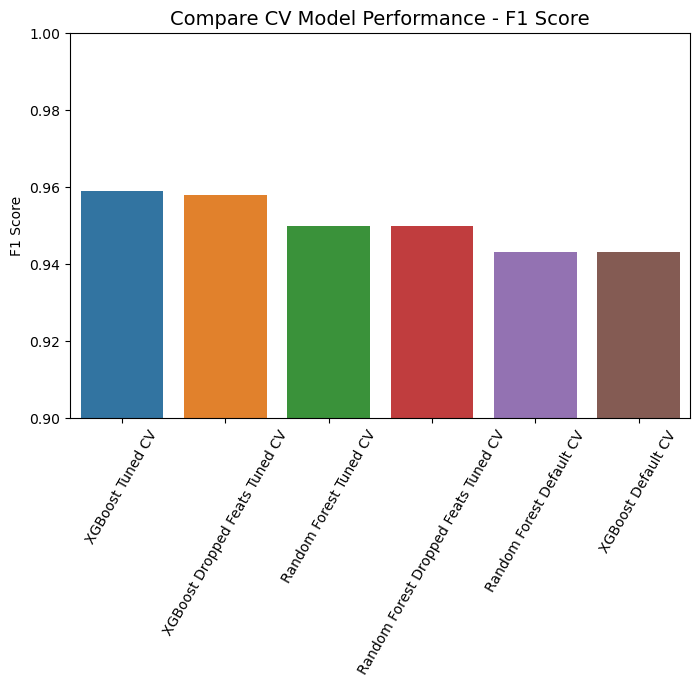

In [160]:
f1 = model_results[['model', 'f1']].sort_values(by=['f1'], ascending=False)
roc_auc = model_results[['model', 'roc_auc']].sort_values(by=['roc_auc'], ascending=False)
precision = model_results[['model', 'precision']].sort_values(by=['precision'], ascending=False)
recall = model_results[['model', 'recall']].sort_values(by=['recall'], ascending=False)

# plot the model performance
plt.figure(figsize=(8, 5))
sns.barplot(data=f1, x='model', y='f1')
plt.title('Compare CV Model Performance - F1 Score', fontsize=14)
plt.xticks(rotation=60)
plt.xlabel('')
plt.ylabel('F1 Score')
plt.ylim(0.9, 1.0)
plt.show()

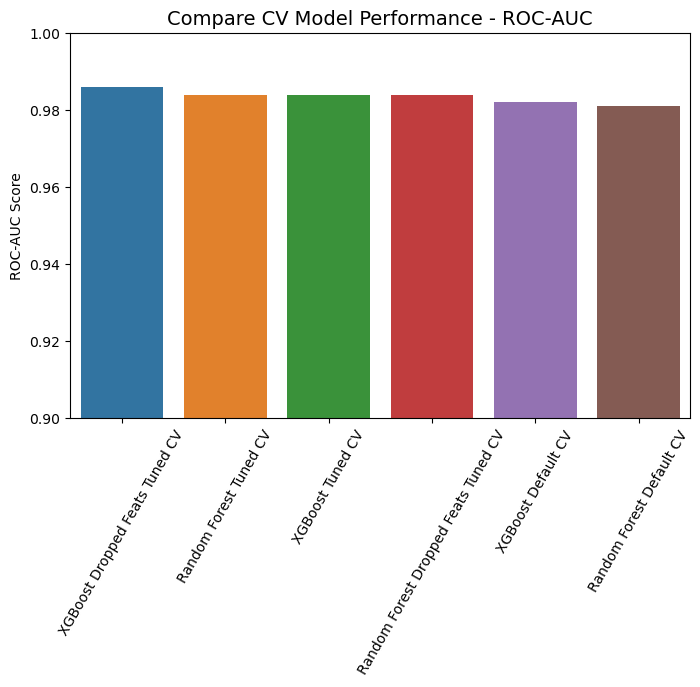

In [161]:
# plot the model performance
plt.figure(figsize=(8, 5))
sns.barplot(data=roc_auc, x='model', y='roc_auc')
plt.title('Compare CV Model Performance - ROC-AUC', fontsize=14)
plt.xticks(rotation=60)
plt.xlabel('')
plt.ylabel('ROC-AUC Score')
plt.ylim(0.9, 1.0)
plt.show()

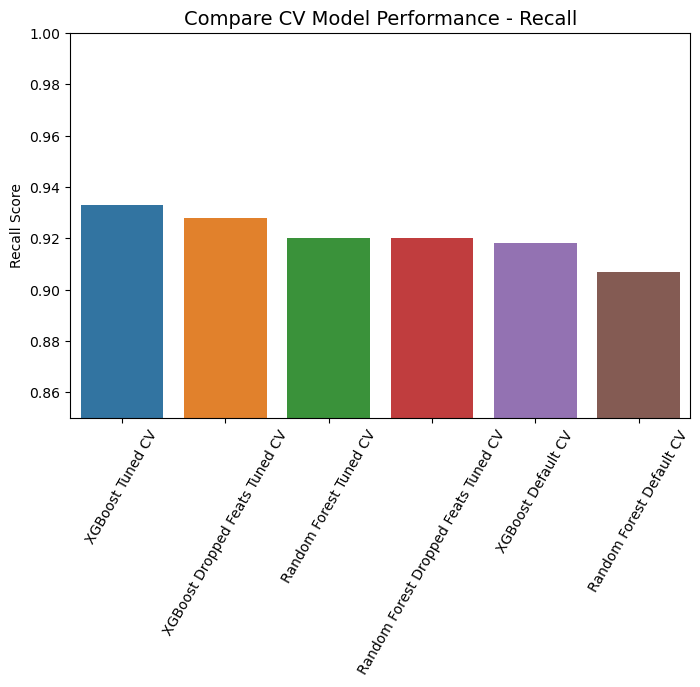

In [162]:
# plot the model performance
plt.figure(figsize=(8, 5))
sns.barplot(data=recall, x='model', y='recall')
plt.title('Compare CV Model Performance - Recall', fontsize=14)
plt.xticks(rotation=60)
plt.xlabel('')
plt.ylabel('Recall Score')
plt.ylim(0.85, 1.0)
plt.show()

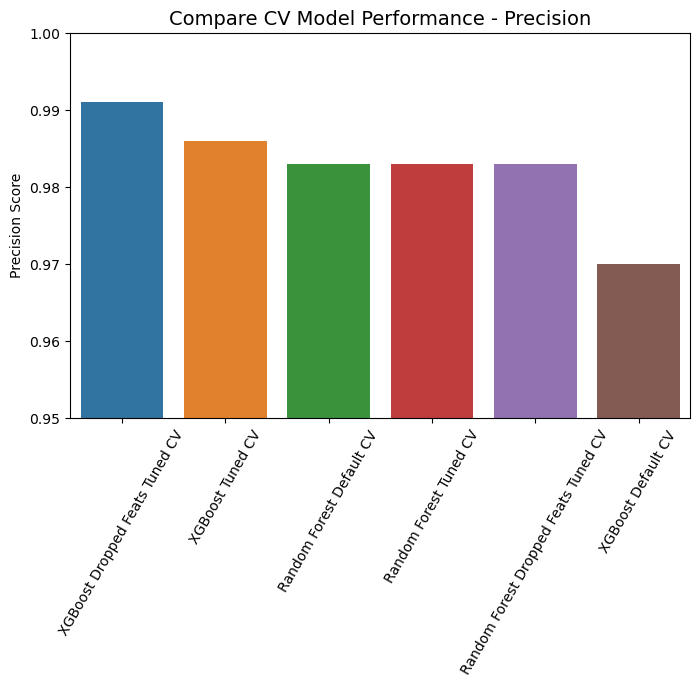

In [163]:
# plot the model performance
plt.figure(figsize=(8, 5))
sns.barplot(data=precision, x='model', y='precision')
plt.title('Compare CV Model Performance - Precision', fontsize=14)
plt.xticks(rotation=60)
plt.xlabel('')
plt.ylabel('Precision Score')
plt.ylim(0.95, 1.0)
plt.show()

## Choose the Best Model
#### **Best Model:** XGBoost Tuned CV
XGBoost Tuned CV has the best F1 score and Recall, while also having the 2nd best Precision. 


## Save the Best Model



In [164]:
# save the xgboost tuned cv model
xgb_best.save_model('../models/best_model.json')

## View the Employees Incorrectly Labeled

In [165]:
xgb_best.n_features_in_

21

In [166]:
print(classification_report(final_y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2500
           1       0.98      0.93      0.95       498

    accuracy                           0.98      2998
   macro avg       0.98      0.96      0.97      2998
weighted avg       0.98      0.98      0.98      2998



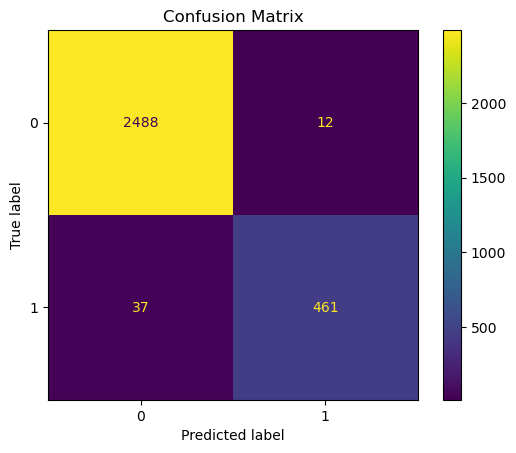

In [167]:
# Load model from file
best_model = XGBClassifier()
best_model.load_model('../models/best_model.json')

# predict on the test data
y_preds = best_model.predict(final_X_test)

# view the confusion matrix
cm = confusion_matrix(final_y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

### Confusion Matrix Analysis:
There are 37 False Negatives. Are these False Negatives randomly distributed? If so, there is likely nothing that can be improved upon.

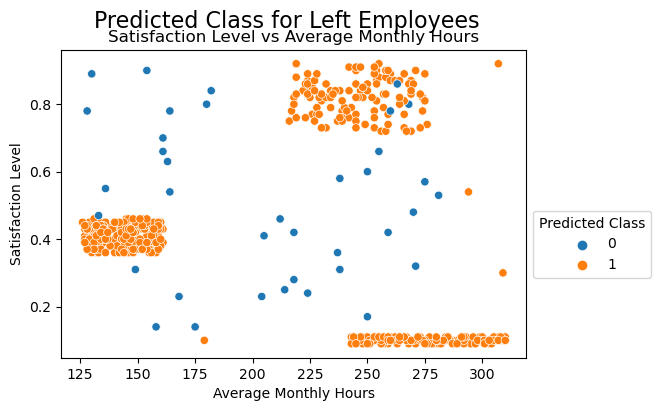

In [177]:
# create a scatter plot of the 'left' employees by satisfaction level and average monthly hours and color by predicted class
plt.figure(figsize=(6, 4))
final_X_test['left'] = final_y_test
final_X_test['predicted_class'] = y_preds
left_df = final_X_test[final_X_test['left'] == 1].copy()
sns.scatterplot(data=left_df, y='satisfaction_level', x='average_monthly_hours', hue='predicted_class')
plt.suptitle('Predicted Class for Left Employees', fontsize=16)
plt.title('Satisfaction Level vs Average Monthly Hours')
plt.xlabel('Average Monthly Hours')
plt.ylabel('Satisfaction Level')
plt.legend(loc='upper left', bbox_to_anchor= (1.0, 0.5), title='Predicted Class')
plt.show()

#### There are three False Negatives that look to be within the High Satisfaction/Medium Hours group.

What are these three characteristics? And how strong in the classification?

In [178]:
mid_sat_df = left_df[(left_df['satisfaction_level'] > 0.7)&(left_df['average_monthly_hours'] > 215)&(left_df['average_monthly_hours'] < 275)]
mid_sat_false_negs = mid_sat_df[mid_sat_df['predicted_class'] == 0]
mid_sat_false_negs

satisfaction_level  last_evaluation  number_project   
620                 0.80             0.75               3  \
116                 0.86             0.68               5   
1450                0.78             0.78               4   

      average_monthly_hours  time_spend_company  work_accident   
620                     268                   2              0  \
116                     263                   2              0   
1450                    260                   5              0   

      promotion_last_5years  time_spend_company_outlier   
620                       0                           0  \
116                       0                           0   
1450                      0                           0   

      over_worked_high_performer  salary_low  ...  department_hr   
620                   753.750000       False  ...          False  \
116                  1039.767442       False  ...          False   
1450                 1040.000000        True  ...          False   

      department_management  department_marketing  department_product_mng   
620                   False                 False                   False  \
116                   False                 False                   False   
1450                  False                 False                   False   

      department_sales  department_support  department_technical   
620               True               False                 False  \
116              False               False                  True   
1450             False               False                 False   

      over_4yr_no_promo_1  left  predicted_class  
620                 False     1                0  
116                 False     1                0  
1450                 True     1                0  

[3 rows x 23 columns]

In [179]:
# get the positive probability for the false negatives
fn_proba_positive = xgb_best.predict_proba(mid_sat_false_negs.drop(columns=['left', 'predicted_class']))[:, 1]



In [180]:
mid_sat_false_negs['pred_prob_pos'] = fn_proba_positive.round(3)
for i, val in mid_sat_false_negs['pred_prob_pos'].items():
    print(f'User Index: {i}')
    print(f'Predicted Probability of Leaving: {round(val*100, 1)}%\n')

User Index: 620
Predicted Probability of Leaving: 0.0%

User Index: 116
Predicted Probability of Leaving: 0.0%

User Index: 1450
Predicted Probability of Leaving: 36.5%



## Results of Analyzing the Three False Negatives
#### The model is Very Confident for two of the False Negatives but one is only moderately confident

### SHAP Values

In [181]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb_best)

data_for_prediction = mid_sat_false_negs.drop(columns=['left', 'predicted_class', 'pred_prob_pos'])

# start with the one with the highest probability of leaving
employee_620 = data_for_prediction.loc[620, :]
employee_116 = data_for_prediction.loc[116, :]

In [182]:
# start with the employee with the highest probability of leaving
data_for_prediction_array = employee_620.values.reshape(1, -1)

# Calculate Shap values 
shap_values = explainer.shap_values(data_for_prediction_array)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, employee_620)

In [183]:
# start with the employee with the highest probability of leaving
data_for_prediction_array = employee_116.values.reshape(1, -1)

# Calculate Shap values 
shap_values = explainer.shap_values(data_for_prediction_array)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, employee_116)

##  Project Questions

#### Key insights about the model
  - The model is quite effective at predicting Employee Churn. The highest Recall model is used since it is more costly to lose an employee by falsely assigning them as not likely to leave. With Recall score of 93% and a F1 score of 95%, this model is balanced and has very few False Negatives (predicting employees will stay when they actually leave).
#### Business recommendations to propose
- Based on the model and this Data Analysis, these are the recommendations:
    - Look at the employees who are in the Low Satisfaction High Performer group and who are classified as likely to leave. Offer them either a promotion or a reduction in hours/projects, or perhaps both. See what they prefer.
    - For the High Satisfaction Mid Performer group who are classified likely to leave, they likely are due for a promotion, which could keep them at the company longer. Since they are mid performers they add value to the company and should be retained.
    - For the Mid Satisfaction Low Performer group who are classified likely to leave, they can take on some of the workload from the High Performer group. This may increase their satisfaction, since they may be bored with the low level of projects they have. As well, this will give them a chance to improve their evaluation score with their manager. If they still choose to leave, it is not as much of a loss to the company since they are not providing a lot of value (low # of projects, low hours)
#### Potential improvements for modeling
  - The model could possibly be improved by doing more feature selection and feature engineering, but overall the False Negatives are fairly randomly distributed and the main patterns are learned. 
    - I would recommend trying the model without the last evaluation feature. 
    - As well, exploring more combined feature for feature interactions might improve some.
#### Next Steps for the Project
- Using the SHAP values, the model can be used to determine what is likely to be the main driver for an individual wanting to leave. That specific item can be discussed and improved for the individual employee. This provides great individualization of HR policy for Retention.
#### Ethical Considerations
- One ethical consideration is that if an individualized policy is generated then it may not be seen as fair. Also, department data may lead to certain types of workers being treated differently. For instance, if a particular department tends to be mostly of one gender, then the geneder data could influence the model indirectly. On the other hand, there is no direct employee info that would be related to a protected class, i.e. gender, race, ethinicity. 



## Step 4. Results and Evaluation


### Summary of model results



### Conclusion, Recommendations, Next Steps

- The model has an accuracy of 98% for classifying Employee Churn.

- The model is fairly balanced in its predictions despite an imbalanced proportion of employees who leave.

- 93% of the time, the model will correctly predict the employees who will leave.

- There are three main groups of employees who are likely to leave:
    - **Low Satisfaction/High Performers:**
        - 4-5 years with the company but not promotion
        - Average Monthly Hours greater than 240
        - 6-7 projects
        - High Evaluation Scores
        - Low Satisfaction Scores
        - **Recommendation:** These employees are very valuable to the company. They are due for a promotion and likely have too high of a work load, so reduce the work load and/or offer a promotion

    - **Mid Satisfaction/Low Performers:**
       - 3 years with the company
       - Average Monthly Hours less than 165
       - 2-3 projects
       - Low Evaluation Scores
       - Mid Satisfaction Scores
       - **Recommendation:** These employees are currently not very valuable to the company. They can take some of the workload from the High  Performers. This could improve retention of the high performers and also possibly increase the retention of this work group. They are possibly bored with the low amount of work. Since this group is not as productive, if they still choose to leave, even after the increase in projects/hours, then they will not be as detrimental. They are typically newer employees and do not drain the company knowledge when they leave.

    - **High Satisfaction/Mid Performers:**
       - Greater than 5 years at the company
       - No Promotion
       - Average Monthly Hours between 215-275
       - 3-5 Projects
       - **Recommenation:** These employees are valuable to the company. They have been at the company a long time and likely have a lot of knowledge of company practices. Without a promotion, they are likely to leave. They are not overworked so their workload should not be redistributed. By offering a promotion, their likelihood of leaving will be reduced.


#### Concluding Statement:

**This model can predict employees that are likely to leave. Then the employee can be grouped into these three categories and managers can propose better changes that will positively impact the employee.**

## Resources Used
- https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
- https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
- https://seaborn.pydata.org/examples/scatterplot_matrix.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
- https://datagy.io/sklearn-one-hot-encode/
- https://jamesrledoux.com/code/randomized_parameter_search
- https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
- https://www.kaggle.com/code/dansbecker/shap-values